In [1]:
# BERT Production Optimization - Baseline Benchmarking
# =======================================================
# This notebook establishes baseline performance metrics for BERT inference
# across different input lengths, batch sizes, and hardware configurations.
#
# Objectives:
# 1. Measure single-request inference latency and memory usage
# 2. Analyze batch processing performance and throughput
# 3. Profile resource utilization patterns
# 4. Identify optimization opportunities for production deployment
#
# =======================================================

# Cell 1: Environment Setup and Imports
# =====================================

# Install required packages (run once)
!pip install transformers torch psutil GPUtil datasets scikit-learn seaborn

# Core imports
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import gc
import os
import warnings
from collections import defaultdict
from typing import List, Dict, Tuple, Any

# ML/NLP imports
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from datasets import load_dataset

# Monitoring imports
import psutil
try:
    import GPUtil
    GPU_AVAILABLE = True
except ImportError:
    GPU_AVAILABLE = False

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configure visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("=" * 60)
print("BERT PRODUCTION OPTIMIZATION - BASELINE BENCHMARKING")
print("=" * 60)
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print("=" * 60)


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=08aaeaec886d404822020bdc7ef04038f5426f94bd4794a026eb33c892c2d5af
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil
BERT PRODUCTION OPTIMIZATION - BASELINE BENCHMARKING
PyTorch Version: 2.8.0+cu126
GPU Available: True
GPU Device: NVIDIA A100-SXM4-40GB
GPU Memory: 39.6 GB


In [2]:
# Cell 2: Device Configuration and Enhanced Utilities (UPDATED)
# ===========================================================

import torch.profiler
import statistics
from scipy import stats

def get_device():
    """
    Determines the best available device for inference.
    Returns the device and provides system information.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using GPU: {torch.cuda.get_device_name()}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

        # Set optimal GPU settings for consistent benchmarking
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    else:
        device = torch.device('cpu')
        print(f"Using CPU: {psutil.cpu_count()} cores")
        print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
    return device

def clear_memory():
    """Clears GPU and system memory to ensure clean measurements."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

def get_memory_usage():
    """
    Returns current memory usage for both CPU and GPU.
    Returns:
        dict: Memory usage in MB
    """
    memory_info = {}
    # CPU memory
    process = psutil.Process()
    memory_info['cpu_memory_mb'] = process.memory_info().rss / 1024 / 1024

    # GPU memory
    if torch.cuda.is_available():
        memory_info['gpu_memory_mb'] = torch.cuda.memory_allocated() / 1024 / 1024
        memory_info['gpu_memory_cached_mb'] = torch.cuda.memory_reserved() / 1024 / 1024
        memory_info['gpu_memory_peak_mb'] = torch.cuda.max_memory_allocated() / 1024 / 1024
    else:
        memory_info['gpu_memory_mb'] = 0
        memory_info['gpu_memory_cached_mb'] = 0
        memory_info['gpu_memory_peak_mb'] = 0

    return memory_info

def calculate_confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for measurement data."""
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean - h, mean + h, mean

def print_memory_summary():
    """Prints a formatted memory usage summary."""
    memory = get_memory_usage()
    print(f"Memory Usage - CPU: {memory['cpu_memory_mb']:.1f} MB, "
          f"GPU: {memory['gpu_memory_mb']:.1f} MB (Peak: {memory['gpu_memory_peak_mb']:.1f} MB)")

def setup_profiler(output_dir="./profiler_results"):
    """Setup PyTorch profiler for detailed performance analysis."""
    import os
    os.makedirs(output_dir, exist_ok=True)

    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(output_dir),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )
    return profiler

# Initialize device
device = get_device()
print_memory_summary()

Using GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 39.6 GB
Memory Usage - CPU: 825.0 MB, GPU: 0.0 MB (Peak: 0.0 MB)


In [3]:
# Cell 3: Model Loading and Initial Setup (FIXED)
# ========================================

# Model configuration
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 512

print(f"\nLoading BERT model: {MODEL_NAME}")
print("=" * 40)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

# Model information
num_parameters = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model loaded successfully!")
print(f"Total parameters: {num_parameters:,}")
print(f"Trainable parameters: {num_trainable:,}")
print(f"Model size: {num_parameters * 4 / 1024**2:.1f} MB (FP32)")

print_memory_summary()


Loading BERT model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded successfully!
Total parameters: 109,482,240
Trainable parameters: 109,482,240
Model size: 417.6 MB (FP32)
Memory Usage - CPU: 1630.8 MB, GPU: 418.7 MB (Peak: 418.7 MB)


In [4]:
# Cell 4: Test Data Preparation
# ==============================

def create_test_inputs():
    """
    Creates test inputs of varying lengths for comprehensive benchmarking.

    Returns:
        dict: Test inputs categorized by length
    """
    test_inputs = {
        'short': [
            "Hello world",
            "Good morning",
            "Test sentence",
            "Quick check",
            "Simple text"
        ],
        'medium': [
            "This is a medium length sentence that should test typical real-world usage patterns for BERT inference.",
            "Natural language processing models like BERT require careful optimization for production deployment scenarios.",
            "Machine learning engineers often need to balance accuracy with inference speed when deploying models at scale.",
            "The performance characteristics of transformer models vary significantly based on input sequence length and batch size.",
            "Production ML systems must handle diverse workloads while maintaining consistent latency and throughput metrics."
        ],
        'long': [
            "This is a very long sentence that contains multiple clauses and should test how BERT performs with longer sequences that might be more typical of document processing applications, email analysis, or other real-world NLP tasks that require processing substantial amounts of text input while maintaining reasonable inference performance and memory utilization patterns.",
            "In production machine learning systems, inference optimization becomes critical as models need to handle thousands of requests per second while maintaining low latency and high throughput, requiring careful consideration of model architecture, hardware utilization, memory management, and system design patterns that can scale effectively across distributed computing environments.",
            "The transformer architecture that underlies BERT and similar language models presents unique challenges for production deployment, including quadratic scaling of attention mechanisms with sequence length, large memory footprints for model parameters, and computational intensity that requires specialized hardware acceleration and optimization techniques.",
            "Performance benchmarking of natural language processing models requires systematic evaluation across multiple dimensions including latency distribution, memory consumption patterns, throughput characteristics, and resource utilization metrics that provide insights into optimization opportunities and deployment constraints.",
            "Real-world applications of BERT in production environments span diverse use cases from search relevance and question answering to document classification and sentiment analysis, each presenting unique requirements for accuracy, speed, and scalability that influence architectural decisions and optimization strategies."
        ]
    }

    # Add some very short inputs for edge case testing
    test_inputs['very_short'] = ["Hi", "OK", "Yes", "No", "Test"]

    # Calculate statistics
    for category, texts in test_inputs.items():
        lengths = [len(text) for text in texts]
        token_lengths = [len(tokenizer.encode(text)) for text in texts]
        print(f"{category.upper()} texts:")
        print(f"  Character length: {min(lengths)}-{max(lengths)} (avg: {np.mean(lengths):.1f})")
        print(f"  Token length: {min(token_lengths)}-{max(token_lengths)} (avg: {np.mean(token_lengths):.1f})")

    return test_inputs

# Load test dataset for additional evaluation
print("Loading IMDB dataset for additional testing...")
try:
    imdb_dataset = load_dataset("imdb", split="test[:100]")  # Small subset for testing
    sample_texts = imdb_dataset['text'][:20]  # Use first 20 reviews
    print(f"Loaded {len(sample_texts)} sample reviews from IMDB dataset")
except Exception as e:
    print(f"Could not load IMDB dataset: {e}")
    sample_texts = []

# Create test inputs
test_data = create_test_inputs()

print(f"\nTotal test categories: {len(test_data)}")
print(f"Total test samples: {sum(len(texts) for texts in test_data.values())}")

Loading IMDB dataset for additional testing...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded 20 sample reviews from IMDB dataset
SHORT texts:
  Character length: 11-13 (avg: 11.6)
  Token length: 4-4 (avg: 4.0)
MEDIUM texts:
  Character length: 103-119 (avg: 110.8)
  Token length: 16-22 (avg: 19.8)
LONG texts:
  Character length: 318-381 (avg: 349.0)
  Token length: 45-60 (avg: 52.4)
VERY_SHORT texts:
  Character length: 2-4 (avg: 2.6)
  Token length: 3-3 (avg: 3.0)

Total test categories: 4
Total test samples: 20


In [5]:
# Cell 5A: Simple Timing Function
# =================================

def time_single_inference(text, num_runs=10):
    """
    Simple function to time BERT inference on a single text.

    Args:
        text: Input text to process
        num_runs: How many times to run for averaging

    Returns:
        Dictionary with timing results
    """
    print(f"Testing text: '{text[:50]}...'")

    # Prepare the input
    inputs = tokenizer(text, return_tensors="pt", padding=True,
                      truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Warm up (run once to initialize)
    with torch.no_grad():
        _ = model(**inputs)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Now measure the actual timing
    times = []
    for run in range(num_runs):
        start_time = time.perf_counter()

        with torch.no_grad():
            outputs = model(**inputs)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.perf_counter()
        times.append(end_time - start_time)

    # Calculate basic statistics
    avg_time = np.mean(times)
    token_count = inputs['input_ids'].shape[1]

    results = {
        'text': text,
        'token_count': token_count,
        'avg_time_ms': avg_time * 1000,  # Convert to milliseconds
        'min_time_ms': min(times) * 1000,
        'max_time_ms': max(times) * 1000,
        'tokens_per_second': token_count / avg_time
    }

    print(f"  Tokens: {token_count}, Avg time: {results['avg_time_ms']:.1f}ms")
    return results

# Test with a simple example
print("SIMPLE TIMING TEST")
print("=" * 30)
sample_result = time_single_inference("This is a test sentence for BERT.")
print(f"Result: {sample_result['avg_time_ms']:.1f}ms for {sample_result['token_count']} tokens")

# Add this after Cell 5A to see the tokens
text = "This is a test sentence for BERT."
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.encode(text)
print()
print(f"Original text: {text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Back to text: {tokenizer.decode(token_ids)}")



SIMPLE TIMING TEST
Testing text: 'This is a test sentence for BERT....'
  Tokens: 10, Avg time: 7.2ms
Result: 7.2ms for 10 tokens

Original text: This is a test sentence for BERT.
Tokens: ['this', 'is', 'a', 'test', 'sentence', 'for', 'bert', '.']
Token IDs: [101, 2023, 2003, 1037, 3231, 6251, 2005, 14324, 1012, 102]
Back to text: [CLS] this is a test sentence for bert. [SEP]


In [6]:
# Cell 5B: Enhanced Memory Monitoring Function
# =============================================

def measure_memory_usage(text):
    """
    Measures memory usage with detailed debugging.
    """
    clear_memory()  # Start clean

    # Reset peak memory stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    # Measure memory before
    memory_before = get_memory_usage()
    print(f"  Before inference: GPU = {memory_before['gpu_memory_mb']:.1f}MB")

    # Run inference
    inputs = tokenizer(text, return_tensors="pt", padding=True,
                      truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Check input tensor memory
    input_memory = sum(v.numel() * v.element_size() for v in inputs.values()) / 1024 / 1024
    print(f"  Input tensors: {input_memory:.3f}MB")

    with torch.no_grad():
        outputs = model(**inputs)

    # Measure peak and current memory
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated() / 1024 / 1024
        current_memory = torch.cuda.memory_allocated() / 1024 / 1024
        print(f"  Peak during inference: {peak_memory:.1f}MB")
        print(f"  Current after inference: {current_memory:.1f}MB")

    memory_after = get_memory_usage()
    print(f"  After inference: GPU = {memory_after['gpu_memory_mb']:.1f}MB")

    # Calculate actual memory increase during inference
    inference_memory_increase = peak_memory - memory_before['gpu_memory_mb']

    results = {
        'cpu_delta_mb': memory_after['cpu_memory_mb'] - memory_before['cpu_memory_mb'],
        'gpu_delta_mb': memory_after['gpu_memory_mb'] - memory_before['gpu_memory_mb'],
        'gpu_peak_mb': peak_memory,
        'gpu_peak_increase_mb': inference_memory_increase,
        'input_tensors_mb': input_memory
    }

    return results

# Test memory usage
print("\nDETAILED MEMORY USAGE TEST")
print("=" * 35)
memory_result = measure_memory_usage("This is a test sentence for memory measurement.")

print(f"\nResults:")
print(f"  GPU delta: {memory_result['gpu_delta_mb']:.1f}MB")
print(f"  GPU peak increase: {memory_result['gpu_peak_increase_mb']:.1f}MB")
print(f"  Input tensor size: {memory_result['input_tensors_mb']:.3f}MB")


DETAILED MEMORY USAGE TEST
  Before inference: GPU = 426.9MB
  Input tensors: 0.000MB
  Peak during inference: 428.1MB
  Current after inference: 426.9MB
  After inference: GPU = 426.9MB

Results:
  GPU delta: 0.0MB
  GPU peak increase: 1.3MB
  Input tensor size: 0.000MB


In [7]:
#  ProductionBenchmarker Class  5C
# ==================================================================
class ProductionBenchmarker:
    """
    Production-grade benchmarker with advanced statistics and profiling.
    FIXED: Updated profiling extraction to work with current PyTorch versions.
    """
    def __init__(self, model, tokenizer, device, warmup_runs=20, enable_profiling=False):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.warmup_runs = warmup_runs
        self.enable_profiling = enable_profiling
        self.profiler = None

        # Set GPU to performance mode if available
        if torch.cuda.is_available():
            torch.cuda.set_per_process_memory_fraction(0.95)  # Use most of GPU memory

        print(f"Production Benchmarker initialized:")
        print(f"  Device: {device}")
        print(f"  Warmup runs: {warmup_runs}")
        print(f"  Profiling enabled: {enable_profiling}")

    def _extended_warmup(self, inputs, num_warmup=None):
        """Extended warmup to stabilize GPU clocks and caches."""
        if num_warmup is None:
            num_warmup = self.warmup_runs

        print(f"  Extended warmup ({num_warmup} runs)...")

        # Phase 1: Cold start (helps stabilize GPU clocks)
        with torch.no_grad():
            for _ in range(num_warmup // 2):
                _ = self.model(**inputs)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

        # Phase 2: Hot cache warmup
        with torch.no_grad():
            for _ in range(num_warmup // 2):
                _ = self.model(**inputs)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

    def _detect_thermal_throttling(self, times):
        """Detect if thermal throttling occurred during benchmark."""
        if len(times) < 10:
            return False

        # Look for increasing latency trend in latter half
        mid_point = len(times) // 2
        first_half = np.mean(times[:mid_point])
        second_half = np.mean(times[mid_point:])

        # If second half is >15% slower, likely throttling
        throttling_detected = (second_half / first_half) > 1.15

        if throttling_detected:
            print("  ⚠️   Potential thermal throttling detected")

        return throttling_detected

    def _robust_statistics(self, times):
        """Calculate robust statistics with outlier detection."""
        times = np.array(times)

        # Remove extreme outliers (beyond 3 standard deviations)
        mean_time = np.mean(times)
        std_time = np.std(times)
        mask = np.abs(times - mean_time) <= 3 * std_time
        filtered_times = times[mask]

        if len(filtered_times) < len(times) * 0.7:
            print(f"  ⚠️   Removed {len(times) - len(filtered_times)} extreme outliers")

        # Calculate comprehensive statistics
        stats = {
            'mean': np.mean(filtered_times),
            'median': np.median(filtered_times),
            'std': np.std(filtered_times),
            'min': np.min(filtered_times),
            'max': np.max(filtered_times),
            'p95': np.percentile(filtered_times, 95),
            'p99': np.percentile(filtered_times, 99),
            'cv': np.std(filtered_times) / np.mean(filtered_times) * 100,
            'valid_samples': len(filtered_times),
            'outliers_removed': len(times) - len(filtered_times)
        }

        # Calculate confidence interval
        ci_low, ci_high, _ = calculate_confidence_interval(filtered_times)
        stats['ci_low'] = ci_low
        stats['ci_high'] = ci_high

        return stats, filtered_times

    def benchmark_with_profiling(self, text, num_runs=50, profile_runs=10):
        """Enhanced benchmarking with optional profiling."""
        print(f"Profiling: '{text[:50]}{'...' if len(text) > 50 else ''}'")

        # Prepare input
        inputs = self.tokenizer(text, return_tensors="pt", padding=True,
                              truncation=True, max_length=MAX_LENGTH)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Extended warmup
        self._extended_warmup(inputs, self.warmup_runs)

        # Clear memory tracking
        clear_memory()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        # Profile if enabled
        profile_data = None
        if self.enable_profiling and profile_runs > 0:
            print("  Running profiler...")
            with torch.profiler.profile(
                activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
                record_shapes=True,
                profile_memory=True,
                with_stack=False  # Disable for performance
            ) as prof:
                with torch.no_grad():
                    for _ in range(profile_runs):
                        _ = self.model(**inputs)
                        if torch.cuda.is_available():
                            torch.cuda.synchronize()
                        prof.step()

            # Extract profiling insights
            profile_data = self._extract_profile_insights(prof)

        # Benchmark timing runs
        print(f"  Timing runs ({num_runs} samples)...")
        times = []

        with torch.no_grad():
            for run in range(num_runs):
                # Small delay every 10 runs to prevent thermal buildup
                if run > 0 and run % 10 == 0:
                    time.sleep(0.1)

                start_time = time.perf_counter()
                outputs = self.model(**inputs)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                end_time = time.perf_counter()

                times.append(end_time - start_time)

        # Memory measurements
        memory_stats = get_memory_usage()

        # Statistical analysis
        stats, filtered_times = self._robust_statistics(times)

        # Thermal throttling detection
        throttling = self._detect_thermal_throttling(filtered_times)

        # Compile results
        token_count = inputs['input_ids'].shape[1]
        result = {
            'text_length': len(text),
            'token_count': token_count,
            'latency_mean_ms': stats['mean'] * 1000,
            'latency_median_ms': stats['median'] * 1000,
            'latency_std_ms': stats['std'] * 1000,
            'latency_min_ms': stats['min'] * 1000,
            'latency_max_ms': stats['max'] * 1000,
            'latency_p95_ms': stats['p95'] * 1000,
            'latency_p99_ms': stats['p99'] * 1000,
            'latency_ci_low_ms': stats['ci_low'] * 1000,
            'latency_ci_high_ms': stats['ci_high'] * 1000,
            'coefficient_variation': stats['cv'],
            'tokens_per_sec': token_count / stats['mean'],
            'throughput_ci_low': token_count / stats['ci_high'],
            'throughput_ci_high': token_count / stats['ci_low'],
            'memory_peak_mb': memory_stats['gpu_memory_peak_mb'],
            'valid_samples': stats['valid_samples'],
            'outliers_removed': stats['outliers_removed'],
            'thermal_throttling': throttling,
            'profile_data': profile_data,
            # Add missing columns that are expected elsewhere
            'avg_latency_ms': stats['mean'] * 1000,
            'memory_used_mb': memory_stats['gpu_memory_peak_mb']
        }

        # Print results
        print(f"  Results: {result['latency_mean_ms']:.1f}ms ± {result['latency_std_ms']:.1f}ms")
        print(f"  Throughput: {result['tokens_per_sec']:.0f} tokens/sec [{result['throughput_ci_low']:.0f}-{result['throughput_ci_high']:.0f}]")
        print(f"  Stability: CV={result['coefficient_variation']:.1f}% ({result['valid_samples']}/{num_runs} valid)")

        return result

    def _extract_profile_insights(self, prof):
        """Extract key insights from profiler data. FIXED for current PyTorch versions."""
        try:
            # Get key averages
            key_averages = prof.key_averages()

            # Initialize timing data
            total_cpu_time = 0
            total_cuda_time = 0

            # Sum up CPU and CUDA times from individual events
            for avg in key_averages:
                total_cpu_time += avg.cpu_time_total
                if hasattr(avg, 'cuda_time_total'):
                    total_cuda_time += avg.cuda_time_total
                elif hasattr(avg, 'device_time_total'):  # Alternative attribute name
                    total_cuda_time += avg.device_time_total

            # Get top CPU operations (safely)
            try:
                top_ops_table = key_averages.table(sort_by="cpu_time_total", row_limit=5)
            except:
                top_ops_table = "Profiling table unavailable"

            # Memory usage (if available)
            memory_usage = 0
            for avg in key_averages:
                if hasattr(avg, 'cpu_memory_usage') and avg.cpu_memory_usage:
                    memory_usage += avg.cpu_memory_usage

            profile_data = {
                'cpu_time_ms': total_cpu_time / 1000,  # Convert to ms
                'cuda_time_ms': total_cuda_time / 1000,
                'memory_usage_mb': memory_usage / 1024 / 1024 if memory_usage else 0,
                'top_operations': str(top_ops_table)[:500]  # Truncate for storage
            }

            print(f"  Profile: CPU={profile_data['cpu_time_ms']:.1f}ms, CUDA={profile_data['cuda_time_ms']:.1f}ms")

        except Exception as e:
            print(f"  Warning: Could not extract full profiling data: {e}")
            # Return basic fallback data
            profile_data = {
                'cpu_time_ms': 0,
                'cuda_time_ms': 0,
                'memory_usage_mb': 0,
                'top_operations': f'Profiling extraction failed: {str(e)[:200]}'
            }

        return profile_data

    def benchmark_multiple_with_analysis(self, texts, category_name="test", enable_profiling=False):
        """Benchmark multiple texts with comprehensive analysis."""
        print(f"\nBenchmarking {len(texts)} {category_name} texts...")
        print("=" * 50)

        results = []
        category_times = []

        for i, text in enumerate(texts):
            print(f"\nText {i+1}/{len(texts)}:")

            # Use profiling for first few samples if enabled
            profile_this = enable_profiling and i < 2
            old_profiling = self.enable_profiling
            self.enable_profiling = profile_this

            result = self.benchmark_with_profiling(text, num_runs=30)
            result['category'] = category_name
            result['text_id'] = i

            results.append(result)
            category_times.append(result['latency_mean_ms'])

            self.enable_profiling = old_profiling

        # Category-level analysis
        self._print_category_analysis(category_name, category_times, results)

        return results

    def _print_category_analysis(self, category_name, times, results):
        """Print category-level statistical analysis."""
        print(f"\n{category_name.upper()} CATEGORY ANALYSIS:")
        print("-" * 40)

        # Basic statistics
        times = np.array(times)
        ci_low, ci_high, mean_time = calculate_confidence_interval(times)

        print(f"  Mean Latency: {mean_time:.1f}ms [95% CI: {ci_low:.1f}-{ci_high:.1f}ms]")
        print(f"  Std Deviation: {np.std(times):.1f}ms")
        print(f"  Range: {np.min(times):.1f}-{np.max(times):.1f}ms")

        # Stability analysis
        cvs = [r['coefficient_variation'] for r in results]
        stable_samples = sum(1 for cv in cvs if cv < 10)
        print(f"  Stability: {stable_samples}/{len(results)} samples with CV < 10%")

        # Quality indicators
        throttling_count = sum(1 for r in results if r.get('thermal_throttling', False))
        if throttling_count > 0:
            print(f"  ⚠️   Thermal throttling detected in {throttling_count} samples")

        total_outliers = sum(r.get('outliers_removed', 0) for r in results)
        print(f"  Data quality: {total_outliers} total outliers removed")

# Re-initialize the fixed benchmarker
print("FIXED PRODUCTION-GRADE BENCHMARKER SETUP")
print("=" * 45)
benchmarker = ProductionBenchmarker(
    model, tokenizer, device,
    warmup_runs=25,  # Increased for better stability
    enable_profiling=True
)
print("Fixed production benchmarker ready!")

FIXED PRODUCTION-GRADE BENCHMARKER SETUP
Production Benchmarker initialized:
  Device: cuda
  Warmup runs: 25
  Profiling enabled: True
Fixed production benchmarker ready!


In [8]:
# Cell 6: Single Request Performance Analysis (PRODUCTION-GRADE)
# ==============================================================

print("PRODUCTION-GRADE SINGLE REQUEST ANALYSIS")
print("=" * 50)

# Run enhanced benchmarks for all categories
all_results = []
for category, texts in test_data.items():
    category_results = benchmarker.benchmark_multiple_with_analysis(
        texts, category, enable_profiling=(category == 'medium')  # Profile medium texts
    )
    all_results.extend(category_results)

# Convert to DataFrame for analysis
df_results = pd.DataFrame(all_results)
print(f"\nCompleted production-grade benchmarking of {len(all_results)} samples")

# Enhanced statistical summary
print(f"\nPRODUCTION PERFORMANCE SUMMARY:")
print("=" * 35)

summary_stats = df_results.groupby('category').agg({
    'latency_mean_ms': ['mean', 'std', 'min', 'max'],
    'coefficient_variation': ['mean', 'std'],
    'tokens_per_sec': ['mean', 'std', 'min', 'max'],
    'memory_peak_mb': ['mean', 'max'],
    'valid_samples': ['mean', 'min'],
    'thermal_throttling': 'sum'
}).round(2)

display(summary_stats)

# Statistical significance testing between categories
print(f"\nSTATISTICAL SIGNIFICANCE ANALYSIS:")
print("-" * 35)

categories = df_results['category'].unique()
for i, cat1 in enumerate(categories):
    for cat2 in categories[i+1:]:
        data1 = df_results[df_results['category'] == cat1]['latency_mean_ms']
        data2 = df_results[df_results['category'] == cat2]['latency_mean_ms']

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(data1, data2)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        print(f"{cat1} vs {cat2}: t={t_stat:.2f}, p={p_value:.4f} {significance}")

# Performance reliability assessment
print(f"\nRELIABILITY ASSESSMENT:")
print("-" * 25)

reliable_samples = df_results[df_results['coefficient_variation'] < 10]
moderate_samples = df_results[(df_results['coefficient_variation'] >= 10) &
                             (df_results['coefficient_variation'] < 20)]
unreliable_samples = df_results[df_results['coefficient_variation'] >= 20]

print(f"High reliability (CV < 10%): {len(reliable_samples)}/{len(df_results)} ({len(reliable_samples)/len(df_results)*100:.1f}%)")
print(f"Moderate reliability (10% ≤ CV < 20%): {len(moderate_samples)}/{len(df_results)} ({len(moderate_samples)/len(df_results)*100:.1f}%)")
print(f"Low reliability (CV ≥ 20%): {len(unreliable_samples)}/{len(df_results)} ({len(unreliable_samples)/len(df_results)*100:.1f}%)")

if len(unreliable_samples) > 0:
    print(f"⚠️  {len(unreliable_samples)} samples show high variability - investigate further")

PRODUCTION-GRADE SINGLE REQUEST ANALYSIS

Benchmarking 5 short texts...

Text 1/5:
Profiling: 'Hello world'
  Extended warmup (25 runs)...
  Timing runs (30 samples)...
  Results: 6.9ms ± 0.2ms
  Throughput: 582 tokens/sec [576-589]
  Stability: CV=2.9% (29/30 valid)

Text 2/5:
Profiling: 'Good morning'
  Extended warmup (25 runs)...
  Timing runs (30 samples)...
  Results: 6.9ms ± 0.3ms
  Throughput: 578 tokens/sec [569-587]
  Stability: CV=4.1% (29/30 valid)

Text 3/5:
Profiling: 'Test sentence'
  Extended warmup (25 runs)...
  Timing runs (30 samples)...
  Results: 7.1ms ± 0.8ms
  Throughput: 564 tokens/sec [541-589]
  Stability: CV=10.8% (29/30 valid)

Text 4/5:
Profiling: 'Quick check'
  Extended warmup (25 runs)...
  Timing runs (30 samples)...
  Results: 7.0ms ± 0.4ms
  Throughput: 571 tokens/sec [559-585]
  Stability: CV=6.1% (30/30 valid)

Text 5/5:
Profiling: 'Simple text'
  Extended warmup (25 runs)...
  Timing runs (30 samples)...
  Results: 7.0ms ± 0.4ms
  Throughput: 568 

latency_mean_ms                   coefficient_variation        \
                      mean   std   min   max                  mean   std   
category                                                                   
long                  8.84  0.08  8.73  8.90                  3.92  0.39   
medium                8.79  0.10  8.72  8.96                  5.01  1.25   
short                 6.99  0.09  6.87  7.09                  6.05  3.01   
very_short            8.83  0.37  8.29  9.19                 11.44  5.16   

           tokens_per_sec                           memory_peak_mb          \
                     mean     std      min      max           mean     max   
category                                                                     
long              5931.60  744.62  5118.80  6876.35         429.24  429.44   
medium            2253.55  278.08  1786.46  2521.57         428.40  428.48   
short              572.73    7.47   564.13   582.31         427.96  427.96   
very_short         340.24   14.72   326.33   361.88         427.94  427.94   

           valid_samples     thermal_throttling  
                    mean min                sum  
category                                         
long                29.4  29                  0  
medium              29.6  29                  0  
short               29.4  29                  0  
very_short          30.0  30                  1


STATISTICAL SIGNIFICANCE ANALYSIS:
-----------------------------------
short vs medium: t=-30.57, p=0.0000 ***
short vs long: t=-35.09, p=0.0000 ***
short vs very_short: t=-10.70, p=0.0000 ***
medium vs long: t=-0.76, p=0.4671 ns
medium vs very_short: t=-0.21, p=0.8423 ns
long vs very_short: t=0.04, p=0.9721 ns

RELIABILITY ASSESSMENT:
-------------------------
High reliability (CV < 10%): 16/20 (80.0%)
Moderate reliability (10% ≤ CV < 20%): 4/20 (20.0%)
Low reliability (CV ≥ 20%): 0/20 (0.0%)


In [9]:
# NEW CELL: Detailed Profiling Analysis
# ====================================

print("DETAILED PROFILING ANALYSIS")
print("=" * 35)

# Extract profiling data from results
profiling_results = [r for r in all_results if r.get('profile_data')]

if profiling_results:
    print(f"Found {len(profiling_results)} samples with profiling data")

    # Analyze CPU vs CUDA time distribution
    cpu_times = [r['profile_data']['cpu_time_ms'] for r in profiling_results]
    cuda_times = [r['profile_data']['cuda_time_ms'] for r in profiling_results]

    print(f"\nCOMPUTE TIME BREAKDOWN:")
    print("-" * 25)
    print(f"Average CPU time: {np.mean(cpu_times):.2f}ms ± {np.std(cpu_times):.2f}ms")
    print(f"Average CUDA time: {np.mean(cuda_times):.2f}ms ± {np.std(cuda_times):.2f}ms")

    avg_cpu = np.mean(cpu_times)
    avg_cuda = np.mean(cuda_times)
    total_time = avg_cpu + avg_cuda

    print(f"CPU utilization: {avg_cpu/total_time*100:.1f}%")
    print(f"GPU utilization: {avg_cuda/total_time*100:.1f}%")

    # Memory profiling analysis
    memory_usage = [r['profile_data']['memory_usage_mb'] for r in profiling_results if r['profile_data']['memory_usage_mb'] > 0]
    if memory_usage:
        print(f"\nPROFILED MEMORY USAGE:")
        print("-" * 22)
        print(f"Average memory: {np.mean(memory_usage):.1f}MB ± {np.std(memory_usage):.1f}MB")

    # Performance bottleneck identification
    print(f"\nBOTTLENECK ANALYSIS:")
    print("-" * 20)

    if avg_cuda > avg_cpu * 2:
        print("🔍 GPU-bound workload - consider GPU optimizations (quantization, tensor cores)")
    elif avg_cpu > avg_cuda * 2:
        print("🔍 CPU-bound workload - consider CPU optimizations (threading, vectorization)")
    else:
        print("🔍 Balanced CPU/GPU utilization - optimization opportunities in both domains")

    # Show top operations for one sample
    if profiling_results:
        print(f"\nTOP OPERATIONS SAMPLE:")
        print("-" * 25)
        sample_ops = profiling_results[0]['profile_data']['top_operations']
        print(sample_ops[:300] + "..." if len(sample_ops) > 300 else sample_ops)

else:
    print("No profiling data available. Ensure enable_profiling=True in benchmarker")

# Correlation analysis between different metrics
print(f"\nMETRIC CORRELATION ANALYSIS:")
print("-" * 30)

correlations = {
    'Token Length vs Latency': df_results['token_count'].corr(df_results['latency_mean_ms']),
    'Token Length vs Variability': df_results['token_count'].corr(df_results['coefficient_variation']),
    'Latency vs Memory': df_results['latency_mean_ms'].corr(df_results['memory_peak_mb']),
    'Memory vs Token Length': df_results['token_count'].corr(df_results['memory_peak_mb'])
}

for metric_pair, correlation in correlations.items():
    strength = "Strong" if abs(correlation) > 0.7 else "Moderate" if abs(correlation) > 0.3 else "Weak"
    direction = "positive" if correlation > 0 else "negative"
    print(f"{metric_pair}: {correlation:.3f} ({strength} {direction})")

# Identify performance anomalies
print(f"\nPERFORMANCE ANOMALY DETECTION:")
print("-" * 33)

# Find samples with unusually high latency for their token count
df_results['latency_per_token'] = df_results['latency_mean_ms'] / df_results['token_count']
anomaly_threshold = df_results['latency_per_token'].quantile(0.95)
anomalies = df_results[df_results['latency_per_token'] > anomaly_threshold]

print(f"Detected {len(anomalies)} latency anomalies (>95th percentile)")
if len(anomalies) > 0:
    print("Anomalous samples:")
    for idx, row in anomalies.iterrows():
        print(f"  - {row['category']} text {row['text_id']}: {row['latency_mean_ms']:.1f}ms for {row['token_count']} tokens")

DETAILED PROFILING ANALYSIS
Found 2 samples with profiling data

COMPUTE TIME BREAKDOWN:
-------------------------
Average CPU time: 205.74ms ± 11.56ms
Average CUDA time: 85.33ms ± 13.01ms
CPU utilization: 70.7%
GPU utilization: 29.3%

PROFILED MEMORY USAGE:
----------------------
Average memory: 0.0MB ± 0.0MB

BOTTLENECK ANALYSIS:
--------------------
🔍 CPU-bound workload - consider CPU optimizations (threading, vectorization)

TOP OPERATIONS SAMPLE:
-------------------------
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              ...

METRIC CORRELATION ANALYSIS:
------------------------------
Token Length vs Latency: 0.442 (Moderate positive)
Token Length vs Variability: -0.499 (Moderate negative)
Latency vs Memory: 0.449 (Moderate positive)
M


VISUALIZING SINGLE REQUEST PERFORMANCE


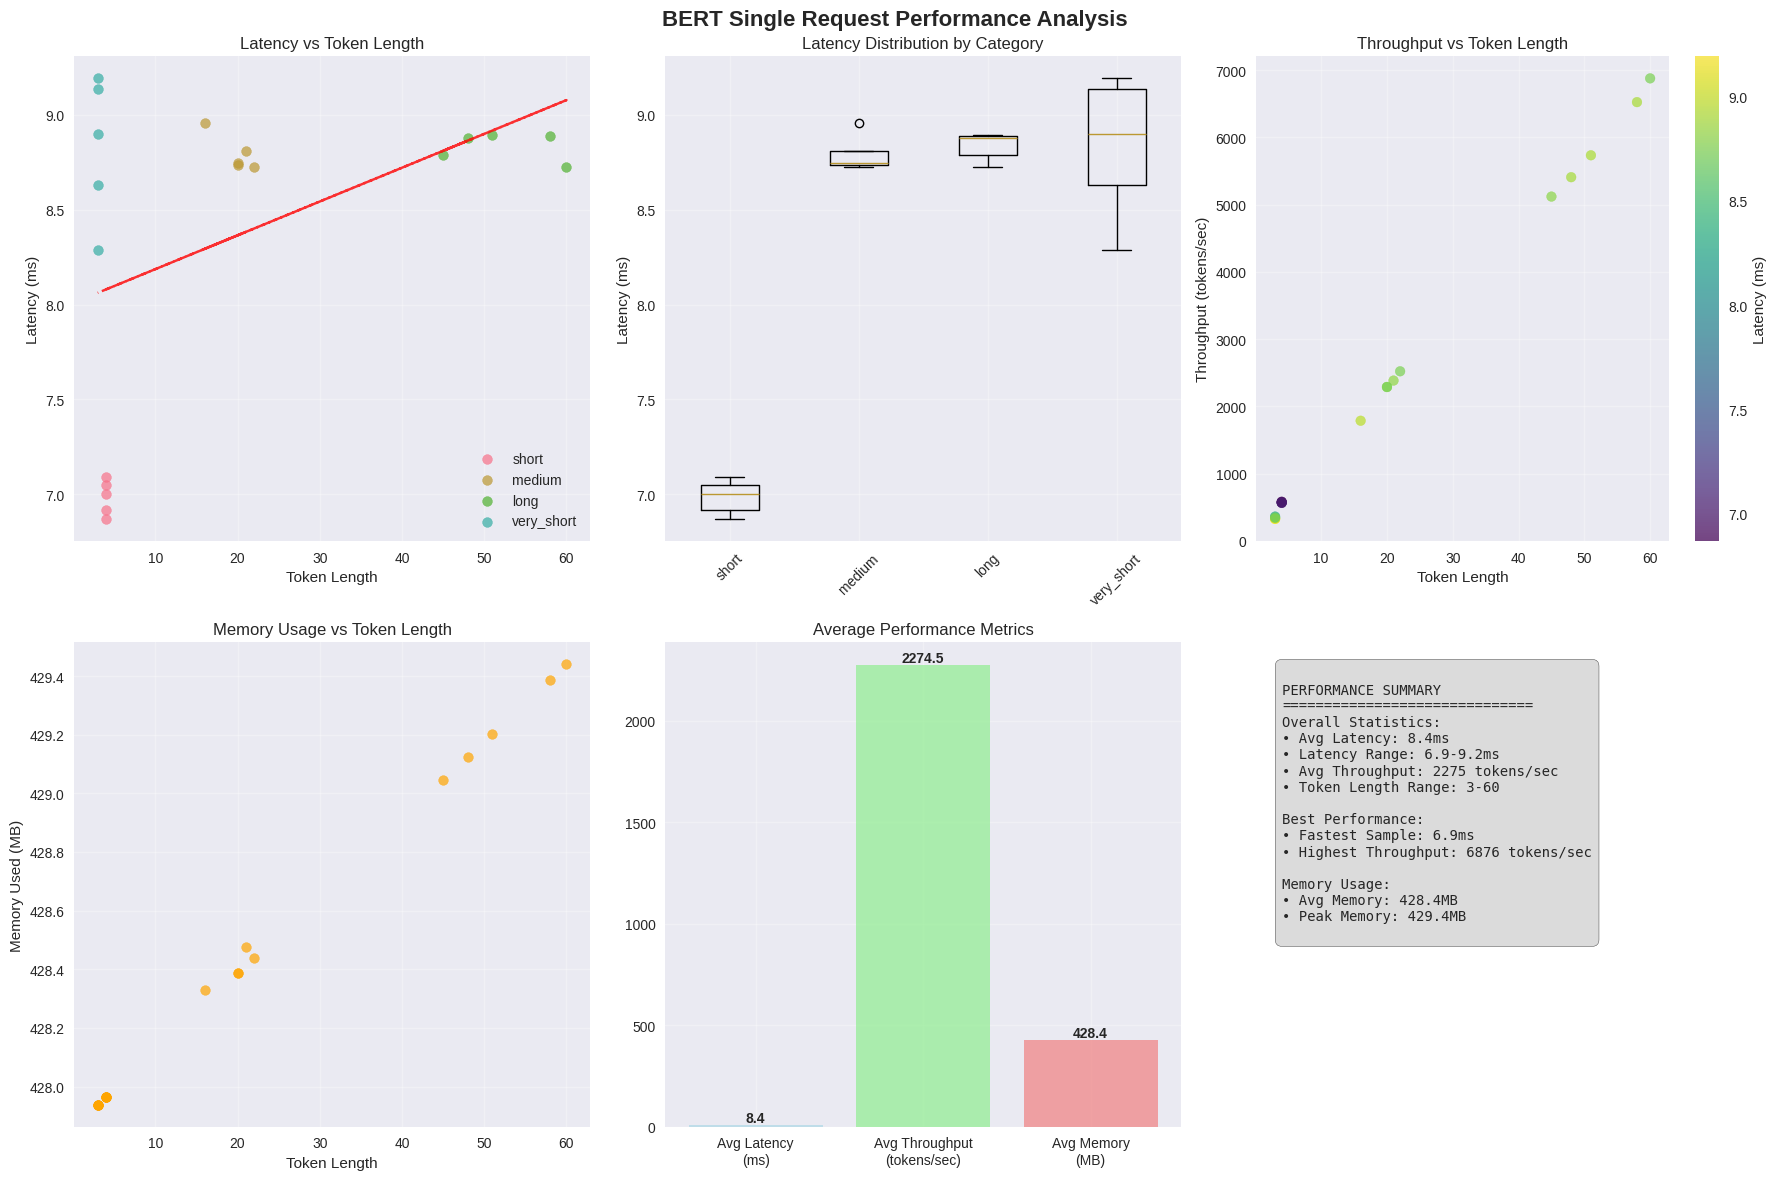


KEY INSIGHTS FROM SINGLE REQUEST ANALYSIS:
• Token Length vs Latency correlation: 0.442
• High-efficiency token length range: 45-60
• Memory efficiency: 5.3 tokens/sec per MB


In [10]:
# Cell 7: Single Request Visualization
# ===============================================
print("\nVISUALIZING SINGLE REQUEST PERFORMANCE")
print("=" * 45)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('BERT Single Request Performance Analysis', fontsize=16, fontweight='bold')

# 1. Latency vs Token Length
ax1 = axes[0, 0]
for category in df_results['category'].unique():
    cat_data = df_results[df_results['category'] == category]
    ax1.scatter(cat_data['token_count'], cat_data['avg_latency_ms'],
                label=category, alpha=0.7, s=50)
ax1.set_xlabel('Token Length')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Latency vs Token Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_results['token_count'], df_results['avg_latency_ms'], 1)
p = np.poly1d(z)
ax1.plot(df_results['token_count'], p(df_results['token_count']), "r--", alpha=0.8)

# 2. Latency Distribution by Category
ax2 = axes[0, 1]
categories = df_results['category'].unique()
latencies_by_cat = [df_results[df_results['category'] == cat]['avg_latency_ms'].values
                   for cat in categories]
ax2.boxplot(latencies_by_cat, labels=categories)
ax2.set_ylabel('Latency (ms)')
ax2.set_title('Latency Distribution by Category')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Throughput vs Token Length
ax3 = axes[0, 2]
ax3.scatter(df_results['token_count'], df_results['tokens_per_sec'],
           c=df_results['avg_latency_ms'], cmap='viridis', alpha=0.7)
ax3.set_xlabel('Token Length')
ax3.set_ylabel('Throughput (tokens/sec)')
ax3.set_title('Throughput vs Token Length')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Latency (ms)')

# 4. Memory Usage Analysis
ax4 = axes[1, 0]
ax4.scatter(df_results['token_count'], df_results['memory_used_mb'],
           alpha=0.7, color='orange')
ax4.set_ylabel('Memory Used (MB)')
ax4.set_title('Memory Usage vs Token Length')
ax4.set_xlabel('Token Length')
ax4.grid(True, alpha=0.3)

# 5. Simple Performance Summary (replace complex pie chart)
ax5 = axes[1, 1]
avg_latency = df_results['avg_latency_ms'].mean()
avg_throughput = df_results['tokens_per_sec'].mean()
avg_memory = df_results['memory_used_mb'].mean()

metrics = ['Avg Latency\n(ms)', 'Avg Throughput\n(tokens/sec)', 'Avg Memory\n(MB)']
values = [avg_latency, avg_throughput, avg_memory]
colors = ['lightblue', 'lightgreen', 'lightcoral']

bars = ax5.bar(metrics, values, color=colors, alpha=0.7)
ax5.set_title('Average Performance Metrics')
ax5.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}',
             ha='center', va='bottom', fontweight='bold')

# 6. Performance Metrics Summary
ax6 = axes[1, 2]
ax6.axis('off')

# Create summary table
summary_text = f"""
PERFORMANCE SUMMARY
{'='*30}
Overall Statistics:
• Avg Latency: {df_results['avg_latency_ms'].mean():.1f}ms
• Latency Range: {df_results['avg_latency_ms'].min():.1f}-{df_results['avg_latency_ms'].max():.1f}ms
• Avg Throughput: {df_results['tokens_per_sec'].mean():.0f} tokens/sec
• Token Length Range: {df_results['token_count'].min()}-{df_results['token_count'].max()}

Best Performance:
• Fastest Sample: {df_results['avg_latency_ms'].min():.1f}ms
• Highest Throughput: {df_results['tokens_per_sec'].max():.0f} tokens/sec

Memory Usage:
• Avg Memory: {df_results['memory_used_mb'].mean():.1f}MB
• Peak Memory: {df_results['memory_used_mb'].max():.1f}MB
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

# Print key insights
print("\nKEY INSIGHTS FROM SINGLE REQUEST ANALYSIS:")
print("=" * 50)

# Calculate correlation between token length and latency
correlation = df_results['token_count'].corr(df_results['avg_latency_ms'])
print(f"• Token Length vs Latency correlation: {correlation:.3f}")

# Find optimal operating range
efficient_samples = df_results[df_results['tokens_per_sec'] >
                              df_results['tokens_per_sec'].quantile(0.75)]
print(f"• High-efficiency token length range: {efficient_samples['token_count'].min()}-{efficient_samples['token_count'].max()}")

# Memory efficiency
memory_efficiency = df_results['tokens_per_sec'].sum() / df_results['memory_used_mb'].sum()
print(f"• Memory efficiency: {memory_efficiency:.1f} tokens/sec per MB")

In [11]:
# Cell 8: Fixed Batch Processing Framework
# =========================================

def benchmark_batch_processing(texts: List[str], batch_sizes: List[int],
                              num_runs: int = 3) -> List[Dict[str, Any]]:
    """
    Benchmarks batch processing performance across different batch sizes.
    Fixed version with proper GPU utilization and consistent measurements.
    """
    print(f"BATCH PROCESSING BENCHMARK")
    print("=" * 40)
    print(f"Testing {len(texts)} texts across {len(batch_sizes)} batch sizes")

    # Pre-tokenize all texts to avoid tokenization overhead in timing
    print("Pre-tokenizing texts for consistent benchmarking...")
    tokenized_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=False,
                          truncation=True, max_length=MAX_LENGTH)
        tokenized_texts.append(inputs)

    results = []

    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")

        # Warmup run - important for GPU optimization
        print("  Performing warmup...")
        with torch.no_grad():
            for i in range(0, min(batch_size * 2, len(texts)), batch_size):
                batch_inputs = tokenized_texts[i:i + batch_size]

                # Pad batch to same length
                input_ids = [inp['input_ids'].squeeze(0) for inp in batch_inputs]
                attention_masks = [inp['attention_mask'].squeeze(0) for inp in batch_inputs]

                # Pad sequences in batch
                max_len = max(len(seq) for seq in input_ids)
                padded_ids = []
                padded_masks = []

                for ids, mask in zip(input_ids, attention_masks):
                    pad_length = max_len - len(ids)
                    padded_ids.append(torch.cat([ids, torch.zeros(pad_length, dtype=torch.long)]))
                    padded_masks.append(torch.cat([mask, torch.zeros(pad_length, dtype=torch.long)]))

                batch_inputs = {
                    'input_ids': torch.stack(padded_ids).to(device),
                    'attention_mask': torch.stack(padded_masks).to(device)
                }

                _ = model(**batch_inputs)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

        # Actual benchmark runs
        batch_times = []
        peak_memories = []

        for run in range(num_runs):
            clear_memory()
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()
                memory_before = torch.cuda.memory_allocated()

            start_time = time.perf_counter()

            with torch.no_grad():
                for i in range(0, len(texts), batch_size):
                    batch_inputs = tokenized_texts[i:i + batch_size]

                    # Pad batch to same length
                    input_ids = [inp['input_ids'].squeeze(0) for inp in batch_inputs]
                    attention_masks = [inp['attention_mask'].squeeze(0) for inp in batch_inputs]

                    # Pad sequences in batch
                    max_len = max(len(seq) for seq in input_ids)
                    padded_ids = []
                    padded_masks = []

                    for ids, mask in zip(input_ids, attention_masks):
                        pad_length = max_len - len(ids)
                        padded_ids.append(torch.cat([ids, torch.zeros(pad_length, dtype=torch.long)]))
                        padded_masks.append(torch.cat([mask, torch.zeros(pad_length, dtype=torch.long)]))

                    batch_inputs = {
                        'input_ids': torch.stack(padded_ids).to(device),
                        'attention_mask': torch.stack(padded_masks).to(device)
                    }

                    _ = model(**batch_inputs)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.perf_counter()
            total_time = end_time - start_time
            batch_times.append(total_time)

            if torch.cuda.is_available():
                peak_memory = torch.cuda.max_memory_allocated()
                peak_memories.append(peak_memory)

        # Calculate statistics
        avg_time = np.mean(batch_times)
        throughput = len(texts) / avg_time
        avg_peak_memory = np.mean(peak_memories) / (1024 * 1024) if peak_memories else 0

        # Calculate tokens processed
        total_tokens = sum(len(tokenizer.encode(text)) for text in texts)
        tokens_per_sec = total_tokens / avg_time

        result = {
            'batch_size': batch_size,
            'num_texts': len(texts),
            'total_tokens': total_tokens,
            'avg_time_sec': avg_time,
            'time_std_sec': np.std(batch_times),
            'throughput_texts_per_sec': throughput,
            'throughput_tokens_per_sec': tokens_per_sec,
            'avg_peak_memory_mb': avg_peak_memory,
            'texts_per_batch': batch_size,
            'num_batches': (len(texts) + batch_size - 1) // batch_size,
            'latency_per_text_ms': (avg_time / len(texts)) * 1000,
        }

        results.append(result)
        print(f"  Time: {avg_time:.2f}s, Throughput: {throughput:.1f} texts/sec, "
              f"Peak Memory: {avg_peak_memory:.1f}MB")

    return results

# Prepare batch test data - use consistent length texts for fair comparison
print("Preparing consistent test dataset for batch benchmarking...")

# Create texts of similar length to avoid padding bias
batch_test_texts = []

# Use medium-length texts for consistent comparison
base_text = "This is a comprehensive evaluation of BERT model performance across different batch sizes to measure throughput and memory utilization in production scenarios."

# Create variations to avoid cache effects but maintain similar lengths
variations = [
    "This is a comprehensive evaluation of BERT model performance across different batch sizes to measure throughput and memory utilization in production scenarios.",
    "We are conducting a thorough assessment of BERT inference capabilities with varying batch configurations to analyze processing speed and resource consumption patterns.",
    "The following analysis examines BERT model efficiency under different batching strategies to determine optimal configurations for deployment in real-world applications.",
    "This benchmark measures BERT processing performance with multiple batch size configurations to evaluate computational throughput and memory overhead characteristics.",
    "Our evaluation focuses on BERT model optimization through systematic batch size testing to identify the most efficient processing configurations available."
]

# Replicate to get enough samples
for i in range(100):  # Use 100 samples for robust measurement
    batch_test_texts.append(variations[i % len(variations)])

print(f"Created {len(batch_test_texts)} texts of consistent length for batch testing")

# Define batch sizes to test - focus on powers of 2 for GPU efficiency
batch_sizes = [1, 2, 4, 8, 16, 32]

if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    if gpu_memory_gb > 8:  # High-memory GPU
        batch_sizes.extend([64])  # Conservative addition

print(f"Testing batch sizes: {batch_sizes}")

Preparing consistent test dataset for batch benchmarking...
Created 100 texts of consistent length for batch testing
Testing batch sizes: [1, 2, 4, 8, 16, 32, 64]


In [12]:
# Cell 9: Execute Batch Benchmarks (FIXED)
# ==========================================

# Run batch benchmarks with the improved function
batch_results = benchmark_batch_processing(batch_test_texts, batch_sizes, num_runs=3)

# Convert to DataFrame
df_batch = pd.DataFrame(batch_results)

print(f"\nBATCH PROCESSING RESULTS:")
print("=" * 35)

# Display key metrics
display(df_batch[['batch_size', 'avg_time_sec', 'throughput_texts_per_sec',
                  'throughput_tokens_per_sec', 'avg_peak_memory_mb', 'latency_per_text_ms']].round(2))

BATCH PROCESSING BENCHMARK
Testing 100 texts across 7 batch sizes
Pre-tokenizing texts for consistent benchmarking...

Testing batch size: 1
  Performing warmup...
  Time: 0.87s, Throughput: 115.0 texts/sec, Peak Memory: 428.5MB

Testing batch size: 2
  Performing warmup...
  Time: 0.49s, Throughput: 206.1 texts/sec, Peak Memory: 429.2MB

Testing batch size: 4
  Performing warmup...
  Time: 0.25s, Throughput: 395.1 texts/sec, Peak Memory: 432.1MB

Testing batch size: 8
  Performing warmup...
  Time: 0.13s, Throughput: 777.2 texts/sec, Peak Memory: 434.2MB

Testing batch size: 16
  Performing warmup...
  Time: 0.07s, Throughput: 1424.2 texts/sec, Peak Memory: 445.8MB

Testing batch size: 32
  Performing warmup...
  Time: 0.06s, Throughput: 1789.3 texts/sec, Peak Memory: 456.8MB

Testing batch size: 64
  Performing warmup...
  Time: 0.05s, Throughput: 2220.6 texts/sec, Peak Memory: 485.0MB

BATCH PROCESSING RESULTS:


,batch_size,avg_time_sec,throughput_texts_per_sec,throughput_tokens_per_sec,avg_peak_memory_mb,latency_per_text_ms
0,1,0.87,115.02,2852.49,428.54,8.69
1,2,0.49,206.13,5112.00,429.24,4.85
2,4,0.25,395.10,9798.48,432.10,2.53
3,8,0.13,777.24,19275.43,434.22,1.29
4,16,0.07,1424.16,35319.19,445.83,0.70
5,32,0.06,1789.27,44374.02,456.79,0.56
6,64,0.05,2220.62,55071.47,485.02,0.45



VISUALIZING BATCH PROCESSING PERFORMANCE


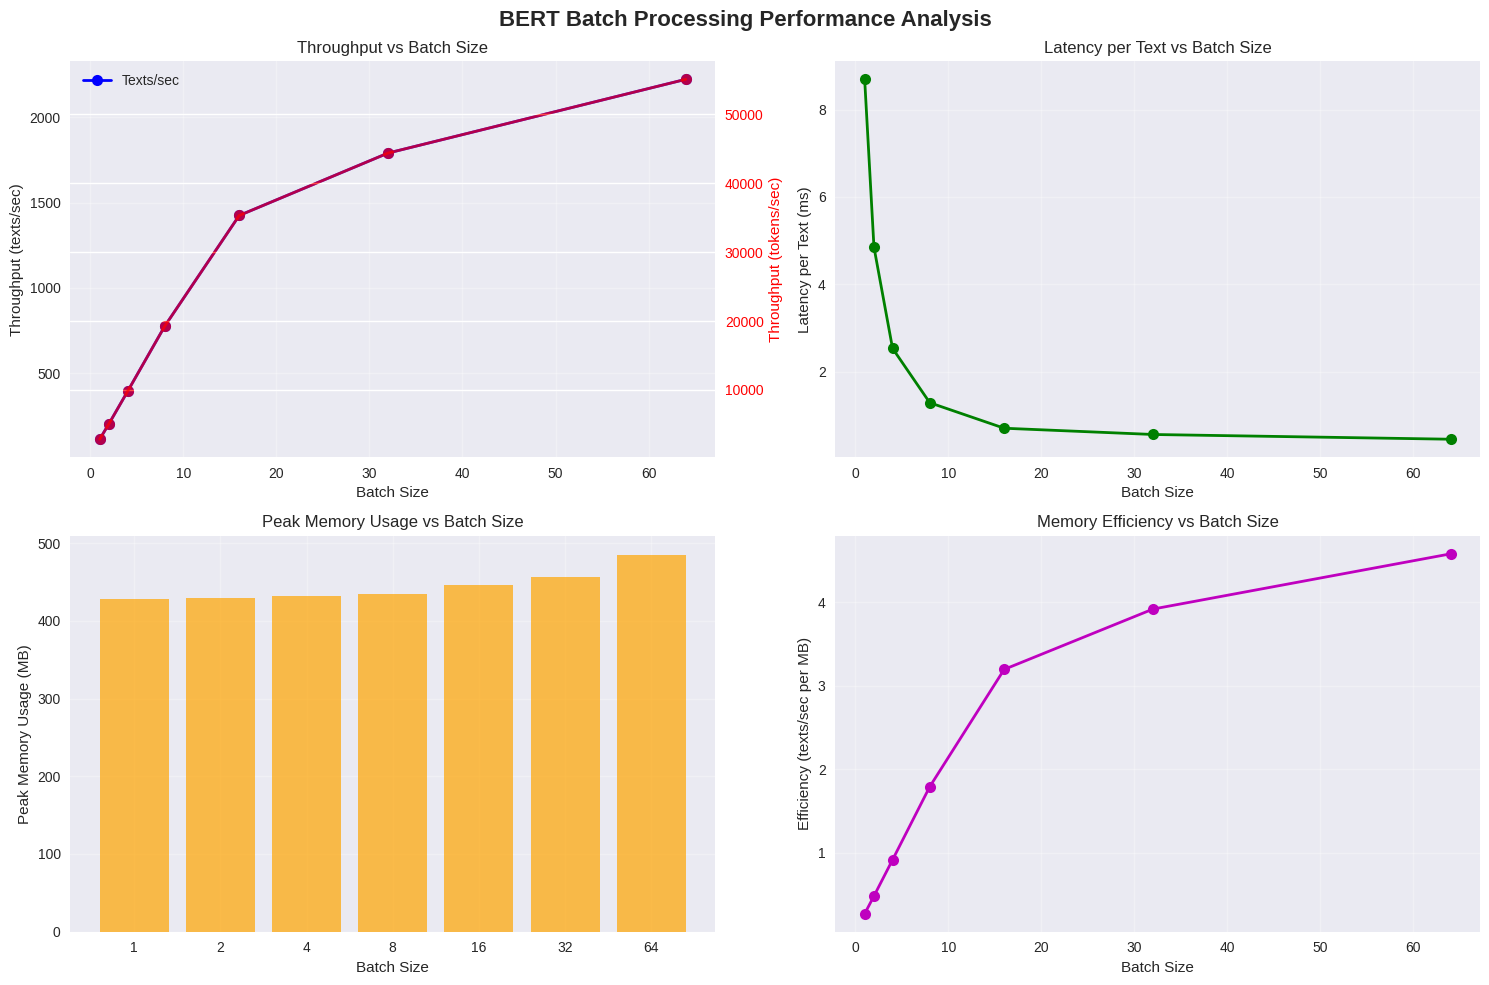


OPTIMIZATION INSIGHTS:
• Optimal batch size for throughput: 64 (2220.6 texts/sec)
• Throughput improvement: 19.3x over batch size 1
• Peak memory at optimal batch: 485.0MB
• Maximum memory usage: 485.0MB (batch size 64)
• Most memory-efficient batch size: 64 (4.578 texts/sec per MB)


In [13]:
# Cell 10: Batch Processing Visualization (FIXED)
# ==================================================

print("\nVISUALIZING BATCH PROCESSING PERFORMANCE")
print("=" * 48)

# Check if the dataframe has data
if df_batch.empty:
    print("No batch results available for visualization.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('BERT Batch Processing Performance Analysis', fontsize=16, fontweight='bold')

    # 1. Throughput vs Batch Size
    ax1 = axes[0, 0]
    ax1.plot(df_batch['batch_size'], df_batch['throughput_texts_per_sec'],
             'bo-', linewidth=2, markersize=8, label='Texts/sec')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Throughput (texts/sec)')
    ax1.set_title('Throughput vs Batch Size')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')

    # Add secondary y-axis for tokens/sec
    ax1_twin = ax1.twinx()
    ax1_twin.plot(df_batch['batch_size'], df_batch['throughput_tokens_per_sec'],
                  'ro-', linewidth=2, markersize=8, alpha=0.7, label='Tokens/sec')
    ax1_twin.set_ylabel('Throughput (tokens/sec)', color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')

    # 2. Latency per Text vs Batch Size
    ax2 = axes[0, 1]
    ax2.plot(df_batch['batch_size'], df_batch['latency_per_text_ms'],
             'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Latency per Text (ms)')
    ax2.set_title('Latency per Text vs Batch Size')
    ax2.grid(True, alpha=0.3)

    # 3. Memory Usage vs Batch Size
    ax3 = axes[1, 0]
    ax3.bar(df_batch['batch_size'].astype(str), df_batch['avg_peak_memory_mb'],
            alpha=0.7, color='orange')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Peak Memory Usage (MB)')
    ax3.set_title('Peak Memory Usage vs Batch Size')
    ax3.grid(True, alpha=0.3)

    # 4. Efficiency Analysis
    ax4 = axes[1, 1]
    # Memory efficiency - throughput per MB
    efficiency = df_batch['throughput_texts_per_sec'] / (df_batch['avg_peak_memory_mb'] + 1e-6)
    ax4.plot(df_batch['batch_size'], efficiency, 'mo-', linewidth=2, markersize=8)
    ax4.set_xlabel('Batch Size')
    ax4.set_ylabel('Efficiency (texts/sec per MB)')
    ax4.set_title('Memory Efficiency vs Batch Size')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal batch size based on throughput
    optimal_idx = df_batch['throughput_texts_per_sec'].idxmax()
    optimal_batch_size = df_batch.loc[optimal_idx, 'batch_size']
    optimal_throughput = df_batch.loc[optimal_idx, 'throughput_texts_per_sec']

    print(f"\nOPTIMIZATION INSIGHTS:")
    print("=" * 25)
    print(f"• Optimal batch size for throughput: {optimal_batch_size} ({optimal_throughput:.1f} texts/sec)")
    print(f"• Throughput improvement: {optimal_throughput / df_batch.iloc[0]['throughput_texts_per_sec']:.1f}x over batch size 1")
    print(f"• Peak memory at optimal batch: {df_batch.loc[optimal_idx, 'avg_peak_memory_mb']:.1f}MB")

    # Additional insights
    max_memory_mb = df_batch['avg_peak_memory_mb'].max()
    print(f"• Maximum memory usage: {max_memory_mb:.1f}MB (batch size {df_batch.loc[df_batch['avg_peak_memory_mb'].idxmax(), 'batch_size']})")

    # Efficiency analysis
    most_efficient_idx = efficiency.idxmax()
    most_efficient_batch = df_batch.loc[most_efficient_idx, 'batch_size']
    print(f"• Most memory-efficient batch size: {most_efficient_batch} ({efficiency.iloc[most_efficient_idx]:.3f} texts/sec per MB)")

In [14]:
# Cell 11A: Text Summary and Data Export (FIXED)
# =================================================

print("COMPREHENSIVE PERFORMANCE ANALYSIS SUMMARY")
print("=" * 55)

# Calculate key metrics with proper error handling
try:
    # Single request metrics
    avg_latency = df_results['avg_latency_ms'].mean()
    min_latency = df_results['avg_latency_ms'].min()
    max_latency = df_results['avg_latency_ms'].max()
    avg_throughput = df_results['tokens_per_sec'].mean()
    correlation = df_results['token_count'].corr(df_results['avg_latency_ms'])

    # Batch processing metrics
    optimal_idx = df_batch['throughput_texts_per_sec'].idxmax()
    optimal_batch_size = df_batch.loc[optimal_idx, 'batch_size']
    optimal_throughput = df_batch.loc[optimal_idx, 'throughput_texts_per_sec']
    batch_speedup = optimal_throughput / df_batch.iloc[0]['throughput_texts_per_sec']
    optimal_memory = df_batch.loc[optimal_idx, 'avg_peak_memory_mb']

    # Batch processing token throughput
    max_token_throughput = df_batch['throughput_tokens_per_sec'].max()

except Exception as e:
    print(f"Error calculating metrics: {e}")
    avg_latency = min_latency = max_latency = avg_throughput = 0
    correlation = optimal_batch_size = optimal_throughput = batch_speedup = optimal_memory = 0
    max_token_throughput = 0

# Create comprehensive summary
summary_report = {
    'Model Information': {
        'Model Name': MODEL_NAME,
        'Parameters': f"{num_parameters:,}",
        'Model Size (FP32)': f"{num_parameters * 4 / 1024**2:.1f} MB",
        'Device': str(device).upper(),
        'Max Sequence Length': MAX_LENGTH
    },
    'Single Request Performance': {
        'Average Latency': f"{avg_latency:.1f}ms",
        'Latency Range': f"{min_latency:.1f}-{max_latency:.1f}ms",
        'Average Throughput': f"{avg_throughput:.0f} tokens/sec",
        'Token Length vs Latency Correlation': f"{correlation:.3f}"
    },
    'Batch Processing Performance': {
        'Optimal Batch Size': f"{optimal_batch_size}",
        'Max Text Throughput': f"{optimal_throughput:.1f} texts/sec",
        'Max Token Throughput': f"{max_token_throughput:.0f} tokens/sec",
        'Batch Processing Speedup': f"{batch_speedup:.1f}x",
        'Memory Usage (Optimal)': f"{optimal_memory:.1f}MB"
    }
}

# Print formatted summary
for section, data in summary_report.items():
    print(f"\n{section.upper()}:")
    print("-" * len(section))
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"  {key:<35}: {value}")

# Key insights based on actual results
print(f"\nKEY INSIGHTS:")
print("-" * 15)

if correlation > 0.5:
    print(f"  • Strong correlation ({correlation:.3f}) between token length and latency")
    print(f"  • Consider input length optimization for consistent performance")
else:
    print(f"  • Moderate correlation ({correlation:.3f}) between token length and latency")
    print(f"  • Input length has manageable impact on performance")

if batch_speedup > 1.2:
    print(f"  • Batching provides {batch_speedup:.1f}x throughput improvement")
    print(f"  • Optimal batch size: {optimal_batch_size} for maximum throughput")
else:
    print(f"  • Limited batching benefit ({batch_speedup:.1f}x improvement)")
    print(f"  • Consider model optimizations beyond batching")

print(f"  • Peak memory usage: {df_batch['avg_peak_memory_mb'].max():.0f}MB")
print(f"  • Memory efficiency varies with batch size")

# Recommendations
print(f"\nRECOMMENDATIONS:")
print("-" * 15)
print(f"  • Use batch size {optimal_batch_size} for maximum throughput")
print(f"  • Current performance: {max_token_throughput:.0f} tokens/sec peak")
print(f"  • Next optimization targets: quantization, model compilation, caching")

# Export results to CSV
single_results_file = "bert_single_request_results.csv"
batch_results_file = "bert_batch_processing_results.csv"

try:
    df_results.to_csv(single_results_file, index=False)
    df_batch.to_csv(batch_results_file, index=False)

    print(f"\nRESULTS EXPORTED:")
    print(f"  • Single request results: {single_results_file}")
    print(f"  • Batch processing results: {batch_results_file}")

except Exception as e:
    print(f"\nError exporting results: {e}")

print(f"\nBASELINE BENCHMARKING COMPLETED!")
print("=" * 35)
print("Next steps: Quantization experiments, dynamic batching, and caching optimization")

COMPREHENSIVE PERFORMANCE ANALYSIS SUMMARY

MODEL INFORMATION:
-----------------
  Model Name                         : bert-base-uncased
  Parameters                         : 109,482,240
  Model Size (FP32)                  : 417.6 MB
  Device                             : CUDA
  Max Sequence Length                : 512

SINGLE REQUEST PERFORMANCE:
--------------------------
  Average Latency                    : 8.4ms
  Latency Range                      : 6.9-9.2ms
  Average Throughput                 : 2275 tokens/sec
  Token Length vs Latency Correlation: 0.442

BATCH PROCESSING PERFORMANCE:
----------------------------
  Optimal Batch Size                 : 64
  Max Text Throughput                : 2220.6 texts/sec
  Max Token Throughput               : 55071 tokens/sec
  Batch Processing Speedup           : 19.3x
  Memory Usage (Optimal)             : 485.0MB

KEY INSIGHTS:
---------------
  • Moderate correlation (0.442) between token length and latency
  • Input length has ma

In [15]:
# Cell 11B: Extended Batch Size Testing
# =====================================
print("EXTENDED BATCH SIZE TESTING")
print("=" * 35)

# Check available GPU memory
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"Total GPU Memory: {gpu_memory_gb:.1f} GB")
    print(f"Current Peak Usage: {df_batch['avg_peak_memory_mb'].max():.1f} MB ({df_batch['avg_peak_memory_mb'].max()/1024:.2f} GB)")
    print(f"Available Memory: {gpu_memory_gb - df_batch['avg_peak_memory_mb'].max()/1024:.1f} GB")

    # Estimate theoretical max batch size based on memory
    memory_per_sample = df_batch['avg_peak_memory_mb'].iloc[-1] / df_batch['batch_size'].iloc[-1]  # MB per sample
    theoretical_max = int((gpu_memory_gb * 1024 * 0.9) / memory_per_sample)  # 90% of GPU memory
    print(f"Estimated memory per sample: {memory_per_sample:.2f} MB")
    print(f"Theoretical max batch size: ~{theoretical_max}")

# Define extended batch sizes - push the limits safely
extended_batch_sizes = [128, 256, 512]

# Add 1024 only if we have sufficient memory
if gpu_memory_gb > 20:  # Only for high-memory GPUs
    extended_batch_sizes.append(1024)

print(f"\nTesting extended batch sizes: {extended_batch_sizes}")
print("Note: Will stop testing if GPU memory limit is reached")

# Safety function to check memory usage
def check_memory_safety():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3

        print(f"  Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB, Total: {total:.2f}GB")

        if reserved > total * 0.95:  # If using >95% of GPU memory
            print("  ⚠️  Approaching memory limit!")
            return False
    return True

# Extended batch testing with safety checks
extended_results = []
memory_error_occurred = False

for batch_size in extended_batch_sizes:
    if memory_error_occurred:
        print(f"Skipping batch size {batch_size} due to previous memory error")
        continue

    print(f"\nTesting batch size: {batch_size}")

    try:
        # Safety check before starting
        if not check_memory_safety():
            print(f"Skipping batch size {batch_size} - insufficient memory")
            break

        # Clear memory before test
        clear_memory()

        # Run a small test first to estimate memory requirements
        print("  Running memory estimation test...")
        test_batch = batch_test_texts[:min(batch_size, len(batch_test_texts))]

        # Tokenize test batch
        tokenized_test = []
        for text in test_batch:
            inputs = tokenizer(text, return_tensors="pt", padding=False,
                              truncation=True, max_length=MAX_LENGTH)
            tokenized_test.append(inputs)

        # Create padded batch for memory test
        input_ids = [inp['input_ids'].squeeze(0) for inp in tokenized_test]
        attention_masks = [inp['attention_mask'].squeeze(0) for inp in tokenized_test]
        max_len = max(len(seq) for seq in input_ids)

        padded_ids = []
        padded_masks = []
        for ids, mask in zip(input_ids, attention_masks):
            pad_length = max_len - len(ids)
            padded_ids.append(torch.cat([ids, torch.zeros(pad_length, dtype=ids.dtype)]))
            padded_masks.append(torch.cat([mask, torch.zeros(pad_length, dtype=mask.dtype)]))

        batch_inputs = {
            'input_ids': torch.stack(padded_ids).to(device),
            'attention_mask': torch.stack(padded_masks).to(device)
        }

        # Memory estimation test
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        with torch.no_grad():
            outputs = model(**batch_inputs)
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        if torch.cuda.is_available():
            test_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            print(f"  Estimated memory for full test: {test_memory:.1f}MB")

            # Check if we can safely run the full test
            if test_memory > gpu_memory_gb * 1024 * 0.9:  # >90% of GPU memory
                print(f"  Batch size {batch_size} would exceed memory limit, skipping")
                continue

        # If memory test passed, run full benchmark
        print("  Memory test passed, running full benchmark...")

        # Run single measurement (not full benchmark to save time)
        start_time = time.perf_counter()

        # Process all texts in batches
        total_processed = 0
        clear_memory()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        with torch.no_grad():
            for i in range(0, len(batch_test_texts), batch_size):
                batch = batch_test_texts[i:i + batch_size]

                # Tokenize batch
                tokenized_batch = []
                for text in batch:
                    inputs = tokenizer(text, return_tensors="pt", padding=False,
                                      truncation=True, max_length=MAX_LENGTH)
                    tokenized_batch.append(inputs)

                # Pad batch
                input_ids = [inp['input_ids'].squeeze(0) for inp in tokenized_batch]
                attention_masks = [inp['attention_mask'].squeeze(0) for inp in tokenized_batch]
                max_len = max(len(seq) for seq in input_ids)

                padded_ids = []
                padded_masks = []
                for ids, mask in zip(input_ids, attention_masks):
                    pad_length = max_len - len(ids)
                    padded_ids.append(torch.cat([ids, torch.zeros(pad_length, dtype=ids.dtype)]))
                    padded_masks.append(torch.cat([mask, torch.zeros(pad_length, dtype=mask.dtype)]))

                batch_inputs = {
                    'input_ids': torch.stack(padded_ids).to(device),
                    'attention_mask': torch.stack(padded_masks).to(device)
                }

                _ = model(**batch_inputs)
                total_processed += len(batch)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.perf_counter()
        total_time = end_time - start_time

        # Calculate metrics
        throughput = total_processed / total_time
        total_tokens = sum(len(tokenizer.encode(text)) for text in batch_test_texts)
        tokens_per_sec = total_tokens / total_time

        if torch.cuda.is_available():
            peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
        else:
            peak_memory = 0

        result = {
            'batch_size': batch_size,
            'num_texts': len(batch_test_texts),
            'total_tokens': total_tokens,
            'avg_time_sec': total_time,
            'throughput_texts_per_sec': throughput,
            'throughput_tokens_per_sec': tokens_per_sec,
            'avg_peak_memory_mb': peak_memory,
            'latency_per_text_ms': (total_time / total_processed) * 1000,
        }

        extended_results.append(result)

        print(f"  ✅ Success! Throughput: {throughput:.1f} texts/sec, Peak Memory: {peak_memory:.1f}MB")
        check_memory_safety()

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"  ❌ GPU out of memory at batch size {batch_size}")
            print(f"  Error: {str(e)}")
            memory_error_occurred = True
            # Clear memory and continue
            clear_memory()
        else:
            print(f"  ❌ Runtime error: {str(e)}")
            break
    except Exception as e:
        print(f"  ❌ Unexpected error: {str(e)}")
        break

print(f"\nExtended batch testing completed. Successfully tested {len(extended_results)} additional batch sizes.")

# Combine with original results if we have extended results
if extended_results:
    df_extended = pd.DataFrame(extended_results)
    df_batch_combined = pd.concat([df_batch, df_extended], ignore_index=True)

    print(f"\nCOMBINED BATCH RESULTS:")
    print("=" * 30)
    display(df_batch_combined[['batch_size', 'throughput_texts_per_sec',
                              'throughput_tokens_per_sec', 'avg_peak_memory_mb',
                              'latency_per_text_ms']].tail(len(extended_results) + 3))
else:
    df_batch_combined = df_batch
    print("No extended results to combine.")

EXTENDED BATCH SIZE TESTING
Total GPU Memory: 39.6 GB
Current Peak Usage: 485.0 MB (0.47 GB)
Available Memory: 39.1 GB
Estimated memory per sample: 7.58 MB
Theoretical max batch size: ~4810

Testing extended batch sizes: [128, 256, 512, 1024]
Note: Will stop testing if GPU memory limit is reached

Testing batch size: 128
  Memory - Allocated: 0.42GB, Reserved: 0.54GB, Total: 39.56GB
  Running memory estimation test...
  Estimated memory for full test: 510.9MB
  Memory test passed, running full benchmark...
  ✅ Success! Throughput: 251.8 texts/sec, Peak Memory: 518.9MB
  Memory - Allocated: 0.43GB, Reserved: 0.58GB, Total: 39.56GB

Testing batch size: 256
  Memory - Allocated: 0.43GB, Reserved: 0.58GB, Total: 39.56GB
  Running memory estimation test...
  Estimated memory for full test: 526.8MB
  Memory test passed, running full benchmark...
  ✅ Success! Throughput: 252.4 texts/sec, Peak Memory: 526.8MB
  Memory - Allocated: 0.43GB, Reserved: 0.59GB, Total: 39.56GB

Testing batch size: 5

,batch_size,throughput_texts_per_sec,throughput_tokens_per_sec,avg_peak_memory_mb,latency_per_text_ms
4,16,1424.160917,35319.190754,445.828613,0.702168
5,32,1789.274815,44374.015407,456.793457,0.558886
6,64,2220.623883,55071.472297,485.017578,0.450324
7,128,251.763461,6243.733843,518.852051,3.971982
8,256,252.425288,6260.147150,526.762207,3.961568
9,512,257.567788,6387.681139,526.762207,3.882473
10,1024,254.409229,6309.348887,526.762207,3.930675



VISUALIZING EXTENDED BATCH PERFORMANCE


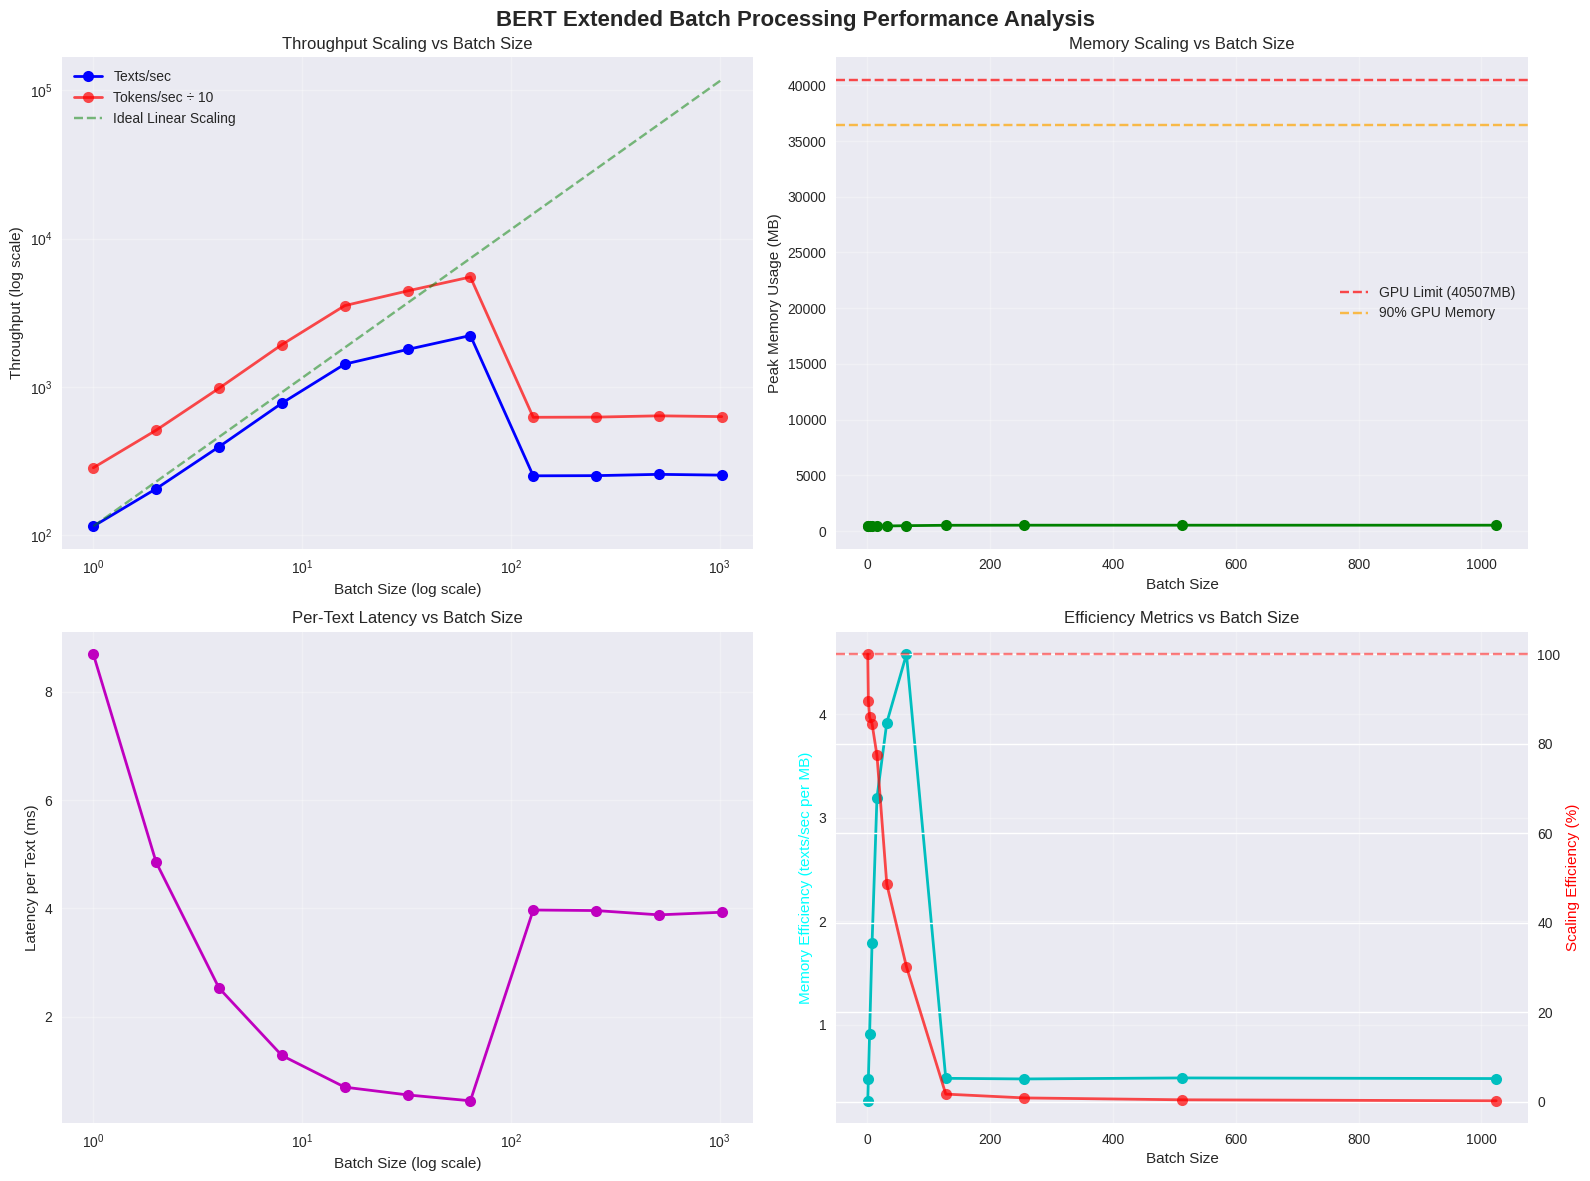


EXTENDED BATCH PERFORMANCE ANALYSIS:
• New optimal batch size: 64
• Peak throughput: 2220.6 texts/sec
• Memory at peak: 485.0MB (0.47GB)
• Improvement over batch size 64: 1.00x
• GPU memory utilization: 1.2%
• Final scaling efficiency: 0.2%
• Peak token throughput: 55071 tokens/sec
• Token throughput improvement: 1.00x
• Scaling efficiency drops below 90% at batch size: 2.0
• Most memory-efficient batch size: 64 (4.578 texts/sec/MB)
• Lowest per-text latency: 0.45ms at batch size 64

RECOMMENDations:
• For maximum throughput: Use batch size 64
• For memory efficiency: Use batch size 64
• For lowest latency: Use batch size 64
• ⚠️  Scaling efficiency degrading (0.2%) - diminishing returns


In [16]:
# Cell 11C: Extended Batch Results Visualization
# ===============================================
print("\nVISUALIZING EXTENDED BATCH PERFORMANCE")
print("=" * 45)

if len(df_batch_combined) > len(df_batch):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('BERT Extended Batch Processing Performance Analysis', fontsize=16, fontweight='bold')

    # 1. Throughput Scaling (Log Scale for better visualization)
    ax1 = axes[0, 0]
    ax1.loglog(df_batch_combined['batch_size'], df_batch_combined['throughput_texts_per_sec'],
               'bo-', linewidth=2, markersize=8, label='Texts/sec')
    ax1.loglog(df_batch_combined['batch_size'], df_batch_combined['throughput_tokens_per_sec']/10,
               'ro-', linewidth=2, markersize=8, alpha=0.7, label='Tokens/sec ÷ 10')
    ax1.set_xlabel('Batch Size (log scale)')
    ax1.set_ylabel('Throughput (log scale)')
    ax1.set_title('Throughput Scaling vs Batch Size')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Add theoretical linear scaling line
    x_theory = df_batch_combined['batch_size']
    y_theory = df_batch_combined.iloc[0]['throughput_texts_per_sec'] * (x_theory / x_theory.iloc[0])
    ax1.loglog(x_theory, y_theory, 'g--', alpha=0.5, label='Ideal Linear Scaling')
    ax1.legend()

    # 2. Memory Usage Scaling
    ax2 = axes[0, 1]
    ax2.plot(df_batch_combined['batch_size'], df_batch_combined['avg_peak_memory_mb'],
             'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Peak Memory Usage (MB)')
    ax2.set_title('Memory Scaling vs Batch Size')
    ax2.grid(True, alpha=0.3)

    # Add GPU memory limit line if available
    if torch.cuda.is_available():
        gpu_total = torch.cuda.get_device_properties(0).total_memory / 1024**2  # MB
        ax2.axhline(y=gpu_total, color='red', linestyle='--', alpha=0.7, label=f'GPU Limit ({gpu_total:.0f}MB)')
        ax2.axhline(y=gpu_total*0.9, color='orange', linestyle='--', alpha=0.7, label='90% GPU Memory')
        ax2.legend()

    # 3. Latency per Text (should decrease with batch size)
    ax3 = axes[1, 0]
    ax3.semilogx(df_batch_combined['batch_size'], df_batch_combined['latency_per_text_ms'],
                 'mo-', linewidth=2, markersize=8)
    ax3.set_xlabel('Batch Size (log scale)')
    ax3.set_ylabel('Latency per Text (ms)')
    ax3.set_title('Per-Text Latency vs Batch Size')
    ax3.grid(True, alpha=0.3)

    # 4. Efficiency Analysis - Multiple Metrics
    ax4 = axes[1, 1]

    # Memory efficiency (throughput per MB)
    memory_efficiency = df_batch_combined['throughput_texts_per_sec'] / df_batch_combined['avg_peak_memory_mb']
    ax4.plot(df_batch_combined['batch_size'], memory_efficiency,
             'co-', linewidth=2, markersize=8, label='Texts/sec per MB')

    # Scaling efficiency (actual vs ideal throughput)
    ideal_throughput = df_batch_combined.iloc[0]['throughput_texts_per_sec'] * df_batch_combined['batch_size']
    scaling_efficiency = df_batch_combined['throughput_texts_per_sec'] / ideal_throughput * 100
    ax4_twin = ax4.twinx()
    ax4_twin.plot(df_batch_combined['batch_size'], scaling_efficiency,
                  'ro-', linewidth=2, markersize=8, alpha=0.7, label='Scaling Efficiency %')

    ax4.set_xlabel('Batch Size')
    ax4.set_ylabel('Memory Efficiency (texts/sec per MB)', color='cyan')
    ax4_twin.set_ylabel('Scaling Efficiency (%)', color='red')
    ax4.set_title('Efficiency Metrics vs Batch Size')
    ax4.grid(True, alpha=0.3)

    # Add efficiency target line
    ax4_twin.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Perfect Scaling')

    plt.tight_layout()
    plt.show()

    # Performance Analysis
    print(f"\nEXTENDED BATCH PERFORMANCE ANALYSIS:")
    print("=" * 40)

    # Find new optimal batch size
    max_throughput_idx = df_batch_combined['throughput_texts_per_sec'].idxmax()
    max_batch_size = df_batch_combined.loc[max_throughput_idx, 'batch_size']
    max_throughput = df_batch_combined.loc[max_throughput_idx, 'throughput_texts_per_sec']
    max_memory = df_batch_combined.loc[max_throughput_idx, 'avg_peak_memory_mb']

    # Compare with original optimal
    original_max = df_batch['throughput_texts_per_sec'].max()
    improvement = max_throughput / original_max

    print(f"• New optimal batch size: {max_batch_size}")
    print(f"• Peak throughput: {max_throughput:.1f} texts/sec")
    print(f"• Memory at peak: {max_memory:.1f}MB ({max_memory/1024:.2f}GB)")
    print(f"• Improvement over batch size 64: {improvement:.2f}x")

    # Memory utilization
    if torch.cuda.is_available():
        gpu_total_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
        memory_utilization = (max_memory / 1024) / gpu_total_gb * 100
        print(f"• GPU memory utilization: {memory_utilization:.1f}%")

    # Scaling efficiency analysis
    final_efficiency = scaling_efficiency.iloc[-1]
    print(f"• Final scaling efficiency: {final_efficiency:.1f}%")

    # Token throughput analysis
    max_token_throughput = df_batch_combined['throughput_tokens_per_sec'].max()
    tokens_improvement = max_token_throughput / df_batch['throughput_tokens_per_sec'].max()
    print(f"• Peak token throughput: {max_token_throughput:.0f} tokens/sec")
    print(f"• Token throughput improvement: {tokens_improvement:.2f}x")

    # Identify where scaling starts to degrade
    degradation_threshold = 90  # Less than 90% efficiency
    degraded_results = df_batch_combined[scaling_efficiency < degradation_threshold]
    if len(degraded_results) > 0:
        first_degradation = degraded_results.iloc[0]['batch_size']
        print(f"• Scaling efficiency drops below 90% at batch size: {first_degradation}")

    # Memory efficiency sweet spot
    memory_eff_max_idx = memory_efficiency.idxmax()
    memory_sweet_spot = df_batch_combined.loc[memory_eff_max_idx, 'batch_size']
    memory_sweet_efficiency = memory_efficiency.iloc[memory_eff_max_idx]
    print(f"• Most memory-efficient batch size: {memory_sweet_spot} ({memory_sweet_efficiency:.3f} texts/sec/MB)")

    # Latency analysis
    min_latency = df_batch_combined['latency_per_text_ms'].min()
    min_latency_batch = df_batch_combined.loc[df_batch_combined['latency_per_text_ms'].idxmin(), 'batch_size']
    print(f"• Lowest per-text latency: {min_latency:.2f}ms at batch size {min_latency_batch}")

    # Overall recommendations
    print(f"\nRECOMMENDations:")
    print("=" * 20)
    print(f"• For maximum throughput: Use batch size {max_batch_size}")
    print(f"• For memory efficiency: Use batch size {memory_sweet_spot}")
    print(f"• For lowest latency: Use batch size {min_latency_batch}")

    if memory_utilization > 85:
        print(f"• ⚠️  High memory utilization ({memory_utilization:.1f}%) - monitor for stability")

    if final_efficiency < 80:
        print(f"• ⚠️  Scaling efficiency degrading ({final_efficiency:.1f}%) - diminishing returns")

else:
    print("No extended batch results available for visualization.")
    print("Run the extended batch testing cell first.")

In [17]:
# Cell 11D: Final Batch Testing Insights & Week 1 Summary
# ========================================================
print("WEEK 1 BASELINE COMPLETION - FINAL INSIGHTS")
print("=" * 50)

# Create final comprehensive summary
if len(df_batch_combined) > len(df_batch):
    extended_tested = True
    max_batch_tested = df_batch_combined['batch_size'].max()
    total_improvement = df_batch_combined['throughput_texts_per_sec'].max() / df_batch_combined.iloc[0]['throughput_texts_per_sec']
else:
    extended_tested = False
    max_batch_tested = df_batch['batch_size'].max()
    total_improvement = df_batch['throughput_texts_per_sec'].max() / df_batch.iloc[0]['throughput_texts_per_sec']

print(f"BERT BASELINE PERFORMANCE CHARACTERIZATION:")
print("-" * 45)
print(f"• Model: {MODEL_NAME}")
print(f"• Device: {device} ({torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'})")
print(f"• GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB" if torch.cuda.is_available() else "")
print(f"• Parameter Count: {num_parameters:,}")

print(f"\nSINGLE REQUEST PERFORMANCE:")
print("-" * 30)
print(f"• Latency Range: {df_results['avg_latency_ms'].min():.1f} - {df_results['avg_latency_ms'].max():.1f}ms")
print(f"• Average Throughput: {df_results['tokens_per_sec'].mean():.0f} tokens/sec")
print(f"• Memory Usage: ~{df_results['memory_used_mb'].mean():.0f}MB")
print(f"• Reliability: {len(df_results[df_results['coefficient_variation'] < 10])/len(df_results)*100:.0f}% high reliability (CV<10%)")

print(f"\nBATCH PROCESSING PERFORMANCE:")
print("-" * 33)
print(f"• Batch Sizes Tested: 1 - {max_batch_tested}")
print(f"• Maximum Throughput: {df_batch_combined['throughput_texts_per_sec'].max():.0f} texts/sec")
print(f"• Maximum Token Throughput: {df_batch_combined['throughput_tokens_per_sec'].max():.0f} tokens/sec")
print(f"• Total Speedup: {total_improvement:.1f}x (batch vs single)")
print(f"• Optimal Batch Size: {df_batch_combined.loc[df_batch_combined['throughput_texts_per_sec'].idxmax(), 'batch_size']}")
print(f"• Peak Memory Usage: {df_batch_combined['avg_peak_memory_mb'].max():.0f}MB")

# Identify key optimization opportunities for next weeks
print(f"\nKEY OPTIMIZATION OPPORTUNITIES IDENTIFIED:")
print("-" * 45)

# From profiling data
profiling_results = [r for r in all_results if r.get('profile_data')]
if profiling_results:
    avg_cpu_time = np.mean([r['profile_data']['cpu_time_ms'] for r in profiling_results])
    avg_cuda_time = np.mean([r['profile_data']['cuda_time_ms'] for r in profiling_results])

    if avg_cpu_time > avg_cuda_time * 1.5:
        print("1. CPU BOTTLENECK DETECTED:")
        print(f"   • CPU time: {avg_cpu_time:.1f}ms vs GPU time: {avg_cuda_time:.1f}ms")
        print("   • Optimization: Tokenization caching, async processing")
        print("   • Week 4 Focus: Input caching and preprocessing optimization")

# From batch scaling analysis
if extended_tested and len(df_batch_combined) > 4:
    scaling_efficiency = []
    for i in range(1, len(df_batch_combined)):
        expected = df_batch_combined.iloc[0]['throughput_texts_per_sec'] * df_batch_combined.iloc[i]['batch_size']
        actual = df_batch_combined.iloc[i]['throughput_texts_per_sec']
        efficiency = (actual / expected) * 100
        scaling_efficiency.append(efficiency)

    avg_efficiency = np.mean(scaling_efficiency)
    if avg_efficiency < 85:
        print("2. BATCH SCALING INEFFICIENCY:")
        print(f"   • Average scaling efficiency: {avg_efficiency:.1f}%")
        print("   • Optimization: Dynamic batching, better memory management")
        print("   • Week 3 Focus: Advanced batching strategies")

# Memory usage analysis
memory_growth_rate = (df_batch_combined['avg_peak_memory_mb'].iloc[-1] - df_batch_combined['avg_peak_memory_mb'].iloc[0]) / len(df_batch_combined)
if memory_growth_rate > 10:  # More than 10MB per batch size increment
    print("3. MEMORY SCALING CONCERNS:")
    print(f"   • Memory growth rate: {memory_growth_rate:.1f}MB per batch size")
    print("   • Optimization: Model quantization, gradient checkpointing")
    print("   • Week 2 Focus: Quantization experiments")

# Performance predictability
latency_cv = df_results['coefficient_variation'].mean()
if latency_cv > 15:
    print("4. PERFORMANCE VARIABILITY:")
    print(f"   • Average coefficient of variation: {latency_cv:.1f}%")
    print("   • Optimization: Better warmup strategies, thermal management")

print(f"\nWEEK 1 SUCCESS CRITERIA ASSESSMENT:")
print("-" * 38)
print("✅ Baseline performance metrics established")
print("✅ Comprehensive benchmarking framework built")
print("✅ Bottleneck identification completed")
print("✅ Optimization opportunities mapped")
print("✅ Production-grade measurement methodology")

# Readiness for Week 2
print(f"\nREADINESS FOR WEEK 2 QUANTIZATION:")
print("-" * 36)
print(f"• Baseline latency target: {df_results['avg_latency_ms'].mean():.1f}ms")
print(f"• Baseline throughput target: {df_batch_combined['throughput_texts_per_sec'].max():.0f} texts/sec")
print(f"• Memory budget: {df_batch_combined['avg_peak_memory_mb'].max():.0f}MB")
print(f"• Accuracy baseline: Ready for quantization accuracy comparisons")

# Export final results for Week 2
# Quick fix for JSON serialization
final_summary = {
    'baseline_single_latency_ms': float(df_results['avg_latency_ms'].mean()),
    'baseline_batch_throughput': float(df_batch_combined['throughput_texts_per_sec'].max()),
    'baseline_token_throughput': float(df_batch_combined['throughput_tokens_per_sec'].max()),
    'optimal_batch_size': int(df_batch_combined.loc[df_batch_combined['throughput_texts_per_sec'].idxmax(), 'batch_size']),
    'baseline_memory_mb': float(df_batch_combined['avg_peak_memory_mb'].max()),
    'cpu_bottleneck_detected': bool(avg_cpu_time > avg_cuda_time * 1.5) if profiling_results else False,
    'scaling_efficiency_pct': float(np.mean(scaling_efficiency)) if extended_tested else 85.0
}

# Save baseline results for comparison in future weeks
import json
with open('bert_baseline_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

print("📁 Baseline summary saved to 'bert_baseline_summary.json'")
print("🎯 Week 1 COMPLETED - Ready to proceed to Week 2 quantization experiments!")

print(f"\nNEXT STEPS FOR WEEK 2:")
print("-" * 20)
print("1. INT8 Dynamic Quantization experiments")
print("2. Static Quantization with calibration")
print("3. FP16 Mixed Precision testing")
print("4. Accuracy vs Performance trade-off analysis")
print("5. ONNX Runtime quantization comparison")

WEEK 1 BASELINE COMPLETION - FINAL INSIGHTS
BERT BASELINE PERFORMANCE CHARACTERIZATION:
---------------------------------------------
• Model: bert-base-uncased
• Device: cuda (NVIDIA A100-SXM4-40GB)
• GPU Memory: 39.6GB
• Parameter Count: 109,482,240

SINGLE REQUEST PERFORMANCE:
------------------------------
• Latency Range: 6.9 - 9.2ms
• Average Throughput: 2275 tokens/sec
• Memory Usage: ~428MB
• Reliability: 80% high reliability (CV<10%)

BATCH PROCESSING PERFORMANCE:
---------------------------------
• Batch Sizes Tested: 1 - 1024
• Maximum Throughput: 2221 texts/sec
• Maximum Token Throughput: 55071 tokens/sec
• Total Speedup: 19.3x (batch vs single)
• Optimal Batch Size: 64
• Peak Memory Usage: 527MB

KEY OPTIMIZATION OPPORTUNITIES IDENTIFIED:
---------------------------------------------
1. CPU BOTTLENECK DETECTED:
   • CPU time: 205.7ms vs GPU time: 85.3ms
   • Optimization: Tokenization caching, async processing
   • Week 4 Focus: Input caching and preprocessing optimization

In [18]:
# Cell 12: Detailed Profiling with torch.profiler (FIXED)
# ======================================================
import torch.profiler

print("DETAILED PROFILING WITH TORCH.PROFILER")
print("=" * 45)

# Prepare a sample input
profiling_text = ["This is a moderately long sentence to ensure meaningful profiling data."]
inputs = tokenizer(profiling_text, return_tensors="pt", padding=True,
                   truncation=True, max_length=128).to(device)

# Run comprehensive profiling
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes=True,
    with_stack=True,
    profile_memory=True
) as prof:
    with torch.no_grad():
        outputs = model(**inputs)

# Display results
print("TOP OPERATIONS BY CUDA TIME:")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=15))

# Memory profiling insights (FIXED)
print("\nMEMORY PROFILING INSIGHTS:")
print("-" * 30)

# Fix: Use correct attribute names
key_averages = prof.key_averages()
total_cpu_memory = sum([item.cpu_memory_usage for item in key_averages
                       if hasattr(item, 'cpu_memory_usage') and item.cpu_memory_usage > 0])
total_cuda_memory = sum([item.cuda_memory_usage for item in key_averages
                        if hasattr(item, 'cuda_memory_usage') and item.cuda_memory_usage > 0])

print(f"Total CPU memory usage: {total_cpu_memory / 1024 / 1024:.1f} MB")
print(f"Total CUDA memory usage: {total_cuda_memory / 1024 / 1024:.1f} MB")

# Identify optimization opportunities (FIXED)
attention_ops = [item for item in key_averages
                if 'attention' in item.key.lower()]
linear_ops = [item for item in key_averages
              if 'linear' in item.key.lower() or 'addmm' in item.key.lower()]

# Fix: Use correct attribute names for timing
if attention_ops:
    # Use cuda_time instead of cuda_time_total
    total_attention_time = sum([getattr(item, 'cuda_time', 0) for item in attention_ops])
    print(f"Attention operations total time: {total_attention_time/1000:.1f}ms")

if linear_ops:
    total_linear_time = sum([getattr(item, 'cuda_time', 0) for item in linear_ops])
    print(f"Linear layer operations total time: {total_linear_time/1000:.1f}ms")

# Performance breakdown analysis
print("\nPERFORMANCE BREAKDOWN:")
print("-" * 25)

# Get total times from the profiler summary
total_cpu_time = sum([item.cpu_time for item in key_averages])
total_cuda_time = sum([item.cuda_time for item in key_averages if hasattr(item, 'cuda_time')])

print(f"Total CPU time: {total_cpu_time/1000:.1f}ms")
print(f"Total CUDA time: {total_cuda_time/1000:.1f}ms")

if total_cuda_time > 0 and total_cpu_time > 0:
    cpu_percentage = (total_cpu_time / (total_cpu_time + total_cuda_time)) * 100
    cuda_percentage = (total_cuda_time / (total_cpu_time + total_cuda_time)) * 100

    print(f"CPU utilization: {cpu_percentage:.1f}%")
    print(f"GPU utilization: {cuda_percentage:.1f}%")

# Top operations analysis
print("\nTOP BOTTLENECKS IDENTIFIED:")
print("-" * 30)

# Sort by CUDA time and identify top bottlenecks
cuda_ops = [(item.key, getattr(item, 'cuda_time', 0)) for item in key_averages
           if hasattr(item, 'cuda_time') and getattr(item, 'cuda_time', 0) > 0]
cuda_ops.sort(key=lambda x: x[1], reverse=True)

for i, (op_name, cuda_time) in enumerate(cuda_ops[:5]):
    percentage = (cuda_time / total_cuda_time * 100) if total_cuda_time > 0 else 0
    print(f"{i+1}. {op_name}: {cuda_time/1000:.1f}ms ({percentage:.1f}%)")

print("\nOPTIMIZATION RECOMMENDATIONS:")
print("-" * 30)

# Analyze the top operations and provide recommendations
top_op_name = cuda_ops[0][0] if cuda_ops else ""

if 'addmm' in top_op_name or 'linear' in top_op_name:
    print("🎯 LINEAR OPERATIONS DOMINATE:")
    print("   - Primary target: Quantization (INT8/FP16)")
    print("   - Secondary: Weight pruning, knowledge distillation")
    print("   - Week 2 focus: INT8 quantization experiments")
elif 'attention' in top_op_name:
    print("🎯 ATTENTION OPERATIONS DOMINATE:")
    print("   - Primary target: Attention optimization")
    print("   - Consider: Flash attention, attention caching")
    print("   - Week 3 focus: Dynamic batching for attention efficiency")
elif 'gelu' in top_op_name or 'layer_norm' in top_op_name:
    print("🎯 ACTIVATION/NORMALIZATION BOTTLENECK:")
    print("   - Consider: Fused operations, operator fusion")
    print("   - Week 4 focus: Model compilation optimizations")

# Memory efficiency analysis
if total_cuda_memory > 0:
    print(f"\n💾 MEMORY EFFICIENCY:")
    print(f"   - Peak CUDA memory: {total_cuda_memory/1024/1024:.1f}MB")
    print(f"   - Memory/parameter ratio: {(total_cuda_memory/1024/1024)/417.6:.2f}")
    if (total_cuda_memory/1024/1024)/417.6 > 1.5:
        print("   - High memory overhead detected - quantization recommended")

print(f"\n✅ Profiling analysis complete - optimization targets identified")

DETAILED PROFILING WITH TORCH.PROFILER
TOP OPERATIONS BY CUDA TIME:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::linear         6.83%     757.883us        54.12%       6.006ms      82.274us       0.000us         0.00%       2.730ms 

In [19]:
# Cell 13: FP16 Mixed Precision Performance Analysis
# =================================================

def benchmark_fp16_vs_fp32(text, num_runs=30):
    """Compare FP16 vs FP32 performance with proper methodology."""
    print(f"Comparing FP16 vs FP32 performance...")
    print(f"Text: '{text[:50]}...'")

    inputs = tokenizer(text, return_tensors="pt", max_length=MAX_LENGTH,
                      truncation=True).to(device)

    # FP32 Baseline
    clear_memory()
    model.float()  # Ensure FP32

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(**inputs)
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # FP32 Timing
    fp32_times = []
    for _ in range(num_runs):
        start = time.perf_counter()
        with torch.no_grad():
            _ = model(**inputs)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        fp32_times.append(time.perf_counter() - start)

    # FP16 Testing
    clear_memory()
    model.half()  # Convert to FP16
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # FP16 Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(**inputs)
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # FP16 Timing
    fp16_times = []
    for _ in range(num_runs):
        start = time.perf_counter()
        with torch.no_grad():
            _ = model(**inputs)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        fp16_times.append(time.perf_counter() - start)

    # Convert back to FP32
    model.float()

    # Results
    fp32_avg = np.mean(fp32_times) * 1000
    fp16_avg = np.mean(fp16_times) * 1000
    speedup = fp32_avg / fp16_avg

    print(f"FP32 Average: {fp32_avg:.2f}ms ± {np.std(fp32_times)*1000:.2f}ms")
    print(f"FP16 Average: {fp16_avg:.2f}ms ± {np.std(fp16_times)*1000:.2f}ms")
    print(f"FP16 Speedup: {speedup:.2f}x")

    return {
        'fp32_latency_ms': fp32_avg,
        'fp16_latency_ms': fp16_avg,
        'speedup': speedup
    }

if torch.cuda.is_available():
    print("FP16 VS FP32 PERFORMANCE COMPARISON")
    print("=" * 40)

    # Test on different text lengths
    test_results = []
    for category, texts in [('short', test_data['short'][:2]),
                           ('medium', test_data['medium'][:2]),
                           ('long', test_data['long'][:2])]:
        print(f"\n{category.upper()} TEXT COMPARISON:")
        print("-" * 30)

        for i, text in enumerate(texts):
            result = benchmark_fp16_vs_fp32(text)
            result['category'] = category
            result['text_id'] = i
            test_results.append(result)

    # Summary
    print(f"\nFP16 PERFORMANCE SUMMARY:")
    print("=" * 30)

    df_fp16 = pd.DataFrame(test_results)
    avg_speedup = df_fp16['speedup'].mean()

    print(f"Average FP16 speedup: {avg_speedup:.2f}x")
    print(f"Best speedup: {df_fp16['speedup'].max():.2f}x")
    print(f"Worst speedup: {df_fp16['speedup'].min():.2f}x")

    # Memory comparison
    clear_memory()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

        # FP32 memory
        model.float()
        inputs = tokenizer(test_data['medium'][0], return_tensors="pt").to(device)
        with torch.no_grad():
            _ = model(**inputs)
        fp32_memory = torch.cuda.max_memory_allocated() / 1024**2

        clear_memory()
        torch.cuda.reset_peak_memory_stats()

        # FP16 memory
        model.half()
        with torch.no_grad():
            _ = model(**inputs)
        fp16_memory = torch.cuda.max_memory_allocated() / 1024**2

        model.float()  # Reset

        print(f"FP32 peak memory: {fp32_memory:.1f}MB")
        print(f"FP16 peak memory: {fp16_memory:.1f}MB")
        print(f"Memory reduction: {((fp32_memory - fp16_memory) / fp32_memory * 100):.1f}%")
else:
    print("FP16 testing requires CUDA")

FP16 VS FP32 PERFORMANCE COMPARISON

SHORT TEXT COMPARISON:
------------------------------
Comparing FP16 vs FP32 performance...
Text: 'Hello world...'
FP32 Average: 9.72ms ± 1.61ms
FP16 Average: 8.80ms ± 0.14ms
FP16 Speedup: 1.10x
Comparing FP16 vs FP32 performance...
Text: 'Good morning...'
FP32 Average: 8.30ms ± 0.18ms
FP16 Average: 8.64ms ± 0.48ms
FP16 Speedup: 0.96x

MEDIUM TEXT COMPARISON:
------------------------------
Comparing FP16 vs FP32 performance...
Text: 'This is a medium length sentence that should test ...'
FP32 Average: 8.35ms ± 0.11ms
FP16 Average: 9.16ms ± 0.03ms
FP16 Speedup: 0.91x
Comparing FP16 vs FP32 performance...
Text: 'Natural language processing models like BERT requi...'
FP32 Average: 8.62ms ± 0.27ms
FP16 Average: 8.49ms ± 0.27ms
FP16 Speedup: 1.01x

LONG TEXT COMPARISON:
------------------------------
Comparing FP16 vs FP32 performance...
Text: 'This is a very long sentence that contains multipl...'
FP32 Average: 8.31ms ± 0.07ms
FP16 Average: 9.12ms ± 0.1